#Simple example notebook accompanying [Economics-Inspired Neural Networks with Stabilizing Homotopies](https://arxiv.org/abs/2303.14802)
In this notebook we illustrate how market clearing layers and stabilizing homotopies, which we introduced in [our recent paper](https://arxiv.org/abs/2303.14802), can be used to improve deep learning based solution methods building on [Deep Equilibrium Nets](https://onlinelibrary.wiley.com/doi/full/10.1111/iere.12575).
While we try to keep this notebook self-contained, more details can be found in the [paper](https://arxiv.org/abs/2303.14802).  
If you have any questions or feedback to the notebook or the [paper](https://arxiv.org/abs/2303.14802), please let us know.  
[Jan](https://janzemlicka.crd.co/): email: jan.zemlicka@cerge-ei.cz  
[Marlon](https://sites.google.com/view/marlonazinovic/home?authuser=0): email: azinovic@sas.upenn.edu  

In [ ]:
'''
    Solve a benchmark two asset OLG model using adiabatic deep learning
'''
'''(1) Import JAX '''
# Install the latest JAXlib version.
USE_CPU = False
USE_GPU = False
USE_TPU = True
if USE_CPU:
  !pip install --upgrade -q pip jaxlib jax
if USE_GPU:
  !pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
if USE_TPU:
  !pip install "jax[tpu]" -f https://storage.googleapis.com/jax-releases/libtpu_releases.html
# Install Haiku neural network library
!pip install --upgrade -q git+https://github.com/deepmind/dm-haiku.git
#Install Optax optimizer library
!pip install --upgrade -q git+https://github.com/deepmind/optax.git
import jax

Looking in links: https://storage.googleapis.com/jax-releases/libtpu_releases.html
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:

if USE_GPU:
  !nvidia-smi

In [ ]:
'''(2) Import libraries '''
from re import S
import jax
import numpy as np
import scipy as sc
import jax.numpy as jnp
from jax import jit,grad,vmap,value_and_grad
import matplotlib.pyplot as plt
import haiku as hk
import optax
from pathlib import Path
import pickle
import statsmodels
import statsmodels.api as sm

# some setup for nice plots
plt.rc('font', family='serif', size = 15)
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('lines', linewidth = 3)
plt.rc('text', usetex = False)

In [ ]:
pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 16.4 MB/s eta 0:00:00


# Model Description

**Uncertainty**

The only source of uncertainty in this economy is a total factor productivity, which follows a normally distributed first-order autoregressive process.

>$\log(z_{t+1}) = \rho_z \log(z_t) + \sigma_z \epsilon_t$

To increase dispersion of returns on capital, we assume that capital depreciation also depends on productivity process.
>$\delta_t = {min} \left\{\delta \frac{2}{1 + z}, 1\right\}$

To ensure that the household problem remain well-posed, we truncate depreciation process at $100 \%$.

**Representative Firm**

The production side of the economy consists of representative firm which has access to Cobb-Douglas production technology that maps labor and capital input into final goods.
>$F(z_t, K_t, L_t) =z_t K_t^{\alpha}L_t^{1-\alpha}$

Factor prices are then pin-down by first-order conditions of representative firm.
>$w_t = \alpha z_t K_t^{\alpha - 1} L_t^{1 - \alpha}$

>$r_t = z_t (1 - \alpha) K_t^{\alpha} L_t^{\alpha}$

Since we assume that $\alpha \in [0,1]$, whole product is splitted between factors of production, and hence we don't need to take stand on firm ownership.

**Households**

Households live deterministically for $H < \infty$ periods, and their preferences over stochastic consumption streams are represented by a time-separable Bernoulli expected utility function. Households maximize this objective by choosing state contingent sequences of consumption and savings in form of capital and bond holdings, subject to household budget constraint, borrowing constraint, no-short sale constraint on capital, and taking prices as given.
>$\mathbb{E}_t \left[\sum_{i = h}^H \beta^{i-h} u(c_{t+i}^{h+i})\right]$

Household felicity function takes the classical constant relative risk aversion form with coefficient $\gamma$.
>$u(c)=\frac{c^{1-\gamma}-1}{1-\gamma}$

Using non-satiation of household preferences, we can rewrite its budget constraint as an equality which states that household consumption and asset purchases had to be equal to its available cash on hand.
>$c_t^h + p_t^b b_{t}^{h} + k_{t}^{h} + \psi^k(k^{h}_t - k^{h-1}_{t-1})^2 = l_t^h w_t + b_{t-1}^{h-1} + k_{t-1}^{h-1}(1 - \delta_t + r_t)$

Borrowing constraint
>$b_t^h \geq b_{min} \quad \forall h,t$

No-short sale on capital
>$k_t^h \geq 0 \quad \forall h,t$

Furthermore, we assume that households can't die in debt.
>$b_t^H \geq 0$

Since the household problem consists a well-behaved concave objective function and convex constraint set, choices of household are characterized by a set of sufficient Karush-Kuhn-Tucker (KKT) conditions. For numerical analysis, we use the Fisher-Burmeister complementarity function to obtain a smooth reformulation of KKT conditions into a single equation respectively.

>$\psi^{FB}(a, b) = a + b -\sqrt{a^2 + b^2}$

Which leads to following functional equations.

>$\psi^{FB}\left(\frac{{u'}^{-1}\left(\beta \mathbb{E} \left[{\frac{1}{p_t^b} u'(c_{t+1}^{h+1})}\right]\right)}{c_t^h} - 1, \frac{b^h_t - \underline{b}}{c_t^h}\right) = 0 \quad \forall \quad 0 < h < H$

>$\psi^{FB}\left(\frac{{u'}^{-1}\left(\beta \mathbb{E} \left[ {u'(c_{t+1}^{h+1})\frac{(1 - \delta_{t+1} - 2 \psi^k (k_{t+1}^{h+1} - k_{t}^{h})}{(1 + 2 \psi^k (k_t^h - k_{t-1}^{h-1}))}} \right] \right)}{c_t^h} - 1, \frac{k_t^h}{c_t^h} \right) = 0 \quad \forall \quad 0 < h < H$

Because households live only for $H < \infty$ periods there are two Fisher-Burmeister functional equations per generation except the last one, since without bequest motive, savings policies of the last generation are trivially zero.

**Market Clearing and Equilibrium**

Aggregate capital, which together with total factor productivity determines wages and return on capital, is a sum of cohort-specific capital stocks.
>$K_t = \sum_{h=1}^H k_t^h$

Bond market clearing conditions require that cohort-specific bond holdings sum up to net supply of bonds denoted by $B$. Specifically, we set the net supply of bonds to zero.
>$0 = B = \sum_{h=1}^H b_t^h$

The numeraire market clears by Walras' law.

**State Variable and Equilibrium Functions**

The state variable of this economy is a vector that collects the (scalar) total factor productivity and the distributions of capital and bond holdings across households with dimensions $H$ and $H$. Hence the dimension of the state of the economy is $1+2 H$. The youngest generation always enters this economy with zero assets, and hence we might reduce state space to only $2H - 1$ variables, we choose not to do so since it simplifies the code to keep this (redundant) inputs.

Regarding policy functions, we choose to approximate household capital and bond savings policies, and back out the implied consumption policies through the budget constraints, since it allows us to simulate state evaluation directly by evaluating neural networks. In addition to $2H -2$ policies, we also need to approximate bond price function.

Rather than approximating each function by a separate neural network, we choose to approximate all those functions as outputs of a single vector-valued neural network. This choice allows neural network to share learned hidden representations across approximated functions.

# Household side
Here we define some constant economic parameters, such as the number of generations ```N_cohort```, the patience ```beta```, the risk aversion ```gamma```, the adjustment costs on capital ```psi_k```, the targeted borrowing limit on capital ```b_min_target```, and the efficient units of (exogenous) labor supply by age ```labor_supply```.

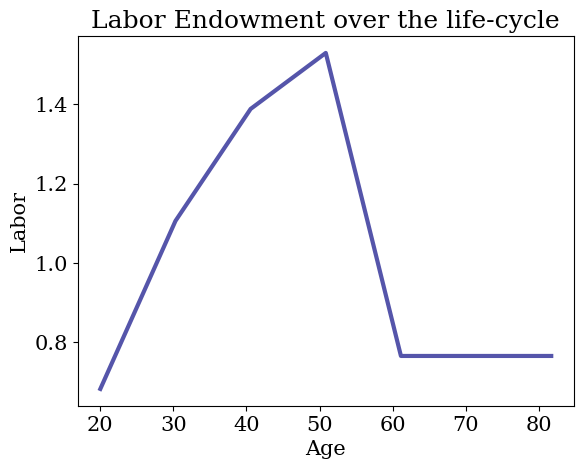

In [ ]:
# number of age groups
N_cohort = 7
N_yearly = 72
plot_age = 20 + np.arange(N_cohort) * (N_yearly / N_cohort)

# patience
beta_yearly = 0.96
beta = beta_yearly**(N_yearly/N_cohort)

# risk aversion
gamma = 2.0

# adjustment costs on capital
psi_k = 0.1

# borrowing constraint
b_min_target = -0.05

# labor endowment over the life cycle
def L_profile(N_cohort):
  LABOR_ENDOW = np.zeros((N_cohort,))  # Labor endowment
  A_IS = int(N_cohort*0.6)  # You work for 2/3 of your adult lifetime
  A_DECR = max(int(0.8*N_cohort), A_IS + 2)
  temp_l = 0.6 + (0.6*1.27/(N_cohort/2.0)**2)*((N_cohort/2.0)**2 - (A_IS - (N_cohort/2.0))**2)
  # Labor endowments like Brumm, Kubler, & Scheidegger (2017), World Congress
  for a in range(N_cohort):
      if a < A_IS:
          LABOR_ENDOW[a] = 0.6 + (0.6 * 1.27 / (N_cohort / 2.) ** 2) * ((N_cohort / 2.) ** 2 - (a - (N_cohort / 2.)) ** 2)
      else:
          LABOR_ENDOW[a] = 0.5 * temp_l
  return jnp.array(LABOR_ENDOW/np.sum(LABOR_ENDOW)*N_cohort)

labor_supply = L_profile(N_cohort)

plt.plot(plot_age,labor_supply,color='navy',alpha=2/3)
plt.title('Labor Endowment over the life-cycle')
plt.xlabel('Age')
plt.ylabel('Labor')
plt.show()

# Technology Section
Next we define paramters governing the firm's production function and the exogenous process for tfp.



In [ ]:
# Production function
alpha = 1/3
delta_cap_yearly = 0.10
delta_cap = 1 - (1. - delta_cap_yearly) ** (N_yearly / N_cohort)

# Scaling utility for ar(1) process
def Sigma_normalize(sigma_e_yearly,rho_z_yearly,N_cohort,N_yearly):
  rho = rho_z_yearly**(N_yearly/N_cohort)
  factor = 0.0
  if N_cohort<=N_yearly:
    for i in range(int(N_yearly/N_cohort)):
      factor += rho_z_yearly**(2*i)
    sigma = factor**(1/2)*sigma_e_yearly
  else:
    for i in range(int(N_cohort/N_yearly)):
      factor += rho**(2*i) # Change! => you need to use the shorter-period rho
    sigma = sigma_e_yearly/factor**(1/2)
  return rho,sigma

# TFP
rho_z_yearly_tfp = 0.85
sigma_e_yearly_tfp = 0.03
rho_z_tfp, sigma_e_tfp = Sigma_normalize(sigma_e_yearly_tfp, rho_z_yearly_tfp, N_cohort, N_yearly)

# Algorithm Choices

As in [Azinovic et. al. (2022)](https://onlinelibrary.wiley.com/doi/full/10.1111/iere.12575), we utilize an iterative algorithm which alters between training (updating) neural network using stochastic gradient descent, and simulating new training samples of states using those updated policy functions. Relative to them, our algorithm always simulate only one step forward before executing an another training phase. To compensate for a shorter simulation step, we use a large number of parallel state trajectories to obtain sufficiently large batches of training data.

The number of parallel state trajectories is denoted by by ```n_cloud```, each cloud is actually used ```epochs_epis``` times, and the minibatch size used to compute loss and its gradient during network training is denoted by ```n_minib```.Number of simulation steps is left to be specified as training function input.

In [ ]:
# Dimension of the state space
d = 1 + 2 * N_cohort          # Aggregate shocks + Capital distribution + Bond distribution

# Build index constants for splitting state vector into corresponding elements
idx_s_tfp_l = 0
idx_s_tfp_u = 1
#
idx_s_k_l = idx_s_tfp_u
idx_s_k_u = idx_s_k_l + N_cohort
#
idx_s_b_l = idx_s_k_u
idx_s_b_u = idx_s_b_l + N_cohort

# Build index constants for splitting output of policy function
idx_o_k_l = 0
idx_o_k_u = idx_o_k_l + (N_cohort-1)
#
idx_o_b_l = idx_o_k_u
idx_o_b_u = idx_o_b_l + (N_cohort-1)
#
idx_o_p_l = idx_o_b_u
idx_o_p_u = idx_o_p_l + 1

# Size of neural network
N = N_cohort * 10

# Learning rate for ADAM gradient descent
Gamma = 1 * 10**(-5)

# Number of states to simulate
n_cloud = 2 ** 13

# Minibatch size for stochastic gradient descent
n_minib = 2 ** 6

# How many times to reuse simulated data
epochs_epis = 3

# Number of gradient descent steps to be performed every simulation step
steps_epoch = int(epochs_epis * n_cloud / n_minib)

# Integrating conditional expectations
num_GH_tfp = 8
eta_tfp, omega_tfp = np.polynomial.hermite.hermgauss(num_GH_tfp)
eta_tfp = jnp.array(eta_tfp) * jnp.sqrt(2)
omega_tfp = jnp.array(omega_tfp)
GH_weights_tfp = omega_tfp / jnp.pi ** 0.5

# Homotopy Parameters

We encode homotopy parameters as a jax.numpy array, and we define index constants that help with recovering those parameters back.

In [ ]:
Homotopy_init = jnp.zeros(shape=(5,))

In [ ]:
idx_h_b_sup = 0
idx_h_b_min = idx_h_b_sup + 1
idx_h_b_msk = idx_h_b_min + 1
idx_h_b_wgh = idx_h_b_msk + 1
idx_h_b_pre = idx_h_b_wgh + 1

  Relative to classical numpy arrays, jax.numpy arrays are immutable, and hence can't be updated using ```Array[i] = x``` syntax. ```jax.numpy``` arrays can be updated using ```Array.at[i].set(x)``` syntax, but that operation creates a new array. Outside ```jax.jit``` compiled functions, this operation might incure a non-trivial overhead.

In [ ]:
Homotopy_init = Homotopy_init.at[idx_h_b_sup].set(0.0)
Homotopy_init = Homotopy_init.at[idx_h_b_min].set(0.0)
Homotopy_init = Homotopy_init.at[idx_h_b_msk].set(0.0)
Homotopy_init = Homotopy_init.at[idx_h_b_wgh].set(0.0)
Homotopy_init = Homotopy_init.at[idx_h_b_pre].set(0.0)

# Define functional forms of some key structures in the economy

Some functions describing structure of the economy are well-defined only for positive input values. To ensure numerical well-behavedness of those functions under floating point arithmetics, we modify original definitions to ensure positive input values for operations which requires those to have well-defined output.

In [ ]:
# useful functions
@jax.jit
def fischer_burmeister(a,b):
  psi = a + b - jnp.sqrt(jnp.abs(a**2 + b**2) + 1e-10)
  return psi

@jax.jit
def u(c):
  c = jnp.maximum(jnp.abs(c), 1e-10)
  if (gamma==1):
    u = jnp.log(c)
  else:
    u = (c**(1-gamma)-1)/(1-gamma)
  return u

@jax.jit
def u_c(c):
  c = jnp.maximum(jnp.abs(c), 1e-10)
  u_c = c**(-gamma)
  return u_c

@jax.jit
def u_c_i(v):
  v = jnp.maximum(jnp.abs(v), 1e-10)
  c = v**(-1 / gamma)
  return c

@jax.jit
def get_firm_side(tfp,K, L):
  # Compute labor supply
  L  = jnp.sum(L)
  # Productivity
  Z = jnp.exp(tfp)
  # Compute output
  Y = Z * (jnp.abs(K) + 10**(-10)) ** alpha * L ** (1 - alpha)
  # Compute marginal products
  rK = alpha * (Y / (jnp.abs(K) + 10**(-10)))
  w = (1. - alpha) * (Y / L)
  return Y, rK, w

# Build Neural Network

Here we are using haiku neural network library to define and initialize neural network which is then used to parametrize equilibrium prices and policy functions.

First, define structure of neural network, and then transform this object (hk.transform) into a pair of pure functions that can be used to initialize and evaluate neural network.

In [ ]:
def base_net_construct(x):
  y = hk.Sequential([hk.Linear(N),jax.nn.selu,
                     hk.Linear(N),jax.nn.selu,
                     hk.Linear(2 * (N_cohort-1) + 1)]) # capital and bond decisions, bond price
  return y(x)

base_net = hk.without_apply_rng(hk.transform(base_net_construct))

To initialize neural network parameters, ```base_net.init``` needs both a random key, since network parameters are randomly initialized, and representative input with the same shape as future network inputs. In our case, the representative input has the same dimension as the state vector.

We initialize log of productivity and bond holdings to zero, and capital holdings to a small positive number. For convenience, we firstly use classical numpy array to use in-place update before redefining it as jax.numpy array.

In [ ]:
representative_input = np.zeros(shape=(d,))
representative_input[(idx_s_k_l+1):idx_s_k_u] = 1.5
representative_input = jnp.array(representative_input)

Relative to numpy random number generator, jax uses local random keys. Functions like [jax.random.uniform](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.uniform.html) or [jax.random.normal](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.normal.html) require specifying not only desired shape of resulting random array, but also random key. If you call those functions repeatly with the same random key, they will finish the same outputs. This feature is useful for debugging, and for code parallelisation.

In [ ]:
init_key = jax.random.PRNGKey(0)

In [ ]:
theta = base_net.init(init_key,representative_input)

# Build Policy Function

Here we build a "policy function" which takes state vector, network parameters, and homotopy parameters as an input, and returns capital/bond policies and bond price as an output. This function ensures non-negative capital policies (no-short sale), and enforces clearing of bond market, as well as non-negativity of bond price.

While the ```S_fun``` is designed to take a single state vector, and produce candidate prices and policies at that state vector, we often need to efficiently evaluate this function on a large set of state vectors. For this purpose, we transform ```S_fun``` using jax [vmap](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html) operator, which transforms this function into ```vS_fun``` which takes as an input a batch of state vectors, and outputs a batch of prices and policies at those states.

We decide to vectorize states along the first axis, hence rows of the input matrix index different state vectors, and columns represent different state elements. Obviously, we do not vectorize network weights and homotopy parameters, since those had to be the same for all states.

In [ ]:
# Build policy function
@jax.jit
def S_fun(x, theta, Homotopy):
  ''' Unpack homotopy parameters '''
  mask_bond = Homotopy[idx_h_b_msk]
  B_supply = Homotopy[idx_h_b_sup]
  #=============================================================================
  # Evaluate network
  prediction = base_net.apply(theta, x)

  #=============================================================================
  # Split outputs
  # Ensure non-negativity of physical capital policies
  k_pred = 0.1*jax.nn.softplus(prediction[idx_o_k_l:idx_o_k_u])

  # Apply homotopy mask on bond policies
  b_pred_pre = mask_bond * prediction[idx_o_b_l:idx_o_b_u]
  # Compute per capita bond excess demand
  b_excess_per_cap = (jnp.sum(b_pred_pre ) - B_supply)/(N_cohort-1)
  # Adjust bond policies
  b_pred = b_pred_pre - b_excess_per_cap

  # Ensure non-negativity of bond price
  p_b_pred = jax.nn.softplus(prediction[idx_o_p_l:idx_o_p_u])

  #=============================================================================
  # construct output
  output = jnp.concatenate([k_pred, b_pred, p_b_pred],axis=0)

  return output

vS_fun = jit(vmap(S_fun,in_axes=(0,None,None)))

# Write Model Equations as Error Function

Here we build a function which evaluates residuals of Fisher-Burmeister functional equations at a particular state vector, given network weights and economic parameters in the homotopy array. This function firstly evaluates policy function given by network weights at the period t state given as a function input, and calculates prices and aggregate quantities given by the state vector. Those allow us to compute implied period t consumption. Savings choice then together with integration rule for t+1 productivity shock realization are used to construct possible t+1 values of the state vector.

The period t procedure is then repeated using vectorized policy function on those possible t+1 state realizations to construct possible t+1 consumption and savings realisations which are then used to evaluate euler equation expectations.

In addition to Fischer-Burmeister errors, this function returns two additional error measures. Firstly, there is negative consumption error. Since we approximate capital and bond policy functions directly, consumption is defined implicitely through budget constraint. Hence, especially at the beginning, where policy functions are still ill-converged, this might imply negative consumption. Since marginal utilities can not be evaluated for zero or negative consumption, we numerically truncate consumption slightly above zero, and return the difference between network-predicted, and corrected consumption as an error term.

Second, we read-off bond implied bond price from bond euler equation of unconstraint agents, and return the difference between network-predicted and implied bond price as an error term. We employ [jax.lax.stop_gradient](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.stop_gradient.html) operator to ensure that the network will learn in the "pretrain" phase backwards in time.

As mentioned above, this function computes equilibrium errors for one particular value of the state vector. However, in the training procedure, we need to evaluate equilibrium errors over large batches of state vectors. Hence, we again vectorize this error function using [vmap](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html) operator.

In [ ]:
@jax.jit
def E(x, theta, Homotopy):
  ''' Period t '''
  # Unpack homotopy parameters
  b_min = Homotopy[idx_h_b_min]

  # Unpack state variables
  tfp_wakeup = x[idx_s_tfp_l:idx_s_tfp_u]
  k_wakeup = x[idx_s_k_l:idx_s_k_u]
  b_wakeup = x[idx_s_b_l:idx_s_b_u]

  # Compute aggregate capital
  K = jnp.sum(k_wakeup)

  # Calculate wages and return to capital
  Y, r, w = get_firm_side(tfp_wakeup, K, labor_supply)

  # Evaluate policy function
  policy = S_fun(x, theta, Homotopy)

  # Calculate current capital depreciation
  delta = jnp.minimum(delta_cap*2/(1+jnp.exp(tfp_wakeup)),1.0)

  # Split policy function outputs
  k_next = policy[idx_o_k_l:idx_o_k_u]
  b_next = policy[idx_o_b_l:idx_o_b_u]
  p_b = policy[idx_o_p_l:idx_o_p_u]

  # Enforce zero savings of the last generation
  k_next = jnp.concatenate([k_next,jnp.array([0.0])],axis=0)
  b_next = jnp.concatenate([b_next,jnp.array([0.0])],axis=0)

  # Compute adjustment costs
  adj_k = psi_k*(k_next-k_wakeup)**2
  marg_adj_k = 2*psi_k*(k_next-k_wakeup)

  # Compute consumption
  c = labor_supply*w + b_wakeup + (1-delta+r)*k_wakeup - p_b*b_next - k_next - adj_k

  # Enforce consumption non-negativity
  c_adj = jnp.maximum(c,10**(-4))

  # Compute marginal utility of period t consumption, drop last consumption, since it doesn't have euler equation
  mu_c = u_c(c_adj[0:(N_cohort-1)])

  # Compute next period shock realizations
  tfp_next = jnp.reshape(rho_z_tfp * tfp_wakeup + sigma_e_tfp * jnp.sqrt(2) * eta_tfp, newshape=(num_GH_tfp,1))

  # Construct next period wake-up assets
  k_next_wakeup = jnp.concatenate([jnp.array([0.0]),k_next[0:(N_cohort-1)]])
  b_next_wakeup = jnp.concatenate([jnp.array([0.0]),b_next[0:(N_cohort-1)]])

  # Construct next period state
  x_next = jnp.concatenate([tfp_next,k_next_wakeup*jnp.ones(shape=(num_GH_tfp,1)),b_next_wakeup*jnp.ones(shape=(num_GH_tfp,1))],axis=1)

  ''' Period t+1 '''
  # Compute aggregate capital
  K_next = jnp.sum(k_next_wakeup)

  # Calculate wages and return to capital
  Y_next, r_next, w_next = get_firm_side(tfp_next,K_next, labor_supply)

  # Evaluate policy function
  policy_next = vS_fun(x_next, theta, Homotopy)

  # Calculate current capital depreciation
  delta_next = jnp.minimum(delta_cap*2/(1+jnp.exp(tfp_next)),1.0)

  # Split policy function outputs
  k_nextnext = policy_next[:,idx_o_k_l:idx_o_k_u]
  b_nextnext = policy_next[:,idx_o_b_l:idx_o_b_u]
  p_b_next = policy_next[:,idx_o_p_l:idx_o_p_u]

  # Enforce zero savings of the last generation
  k_nextnext = jnp.concatenate([k_nextnext,jnp.zeros(shape=(num_GH_tfp,1))],axis=1)
  b_nextnext = jnp.concatenate([b_nextnext,jnp.zeros(shape=(num_GH_tfp,1))],axis=1)

  # Compute adjustment costs
  adj_k_next = psi_k*(k_nextnext-k_next_wakeup)**2
  marg_adj_k_next = 2*psi_k*(k_nextnext-k_next_wakeup)
  print('labor_supply shape:', labor_supply.shape)
  print('w_next shape:', w_next.shape)
  print('b_next_wakeup shape:', b_next_wakeup.shape)
  print('delta_next shape:', delta_next.shape)
  print('r_next shape:', r_next.shape)
  print('k_next_wakeup shape:', k_next_wakeup.shape)
  print('p_b_next shape:', p_b_next.shape)
  print('b_nextnext shape:', b_nextnext.shape)
  print('k_nextnext shape:', k_nextnext.shape)
  print('adj_k_next shape:', adj_k_next.shape)

  # Compute consumption
  c_next = labor_supply*w_next + b_next_wakeup + (1-delta_next+r_next)*k_next_wakeup - p_b_next*b_nextnext - k_nextnext - adj_k_next

  # Enforce consumption non-negativity
  c_next_adj = jnp.maximum(c_next,10**(-4))

  # Marginal utility of t+1 consumption => drop the first element of consumption, since that never enters into expectations
  mu_c_next = u_c(c_next_adj[:,1:N_cohort])

  # Compute expectations for bond euler equations
  expect_b = jnp.dot(GH_weights_tfp,mu_c_next)

  # Compute expectations for capital euler equations, remember first cohort adjustment costs never enter expectations, make sure that return is non-negative
  expect_k = jnp.dot(GH_weights_tfp,mu_c_next*jnp.maximum((1-delta_next+r_next+marg_adj_k_next[:,1:N_cohort]),10**(-4)))

  # Compute bond price implied by bond euler equations
  p_b_implied = jnp.max(beta*expect_b/mu_c)

  # Calculate relative consumption error in capital euler equation, remember that adjustment costs and consumption of the last cohort in period t doesn't enter lhs
  fb_k_a = u_c_i(beta*expect_k/jnp.maximum((1+marg_adj_k[0:(N_cohort-1)]),10**(-4)))/c_adj[0:(N_cohort-1)] - 1
  fb_k_b = (k_next[0:(N_cohort-1)]-0.0)/c_adj[0:(N_cohort-1)]

  eps_kee = fischer_burmeister(fb_k_a,fb_k_b)

  # Calculate relative fischer-burmeister terms of bond optimality
  fb_b_a = u_c_i(beta*expect_b/p_b)/c_adj[0:(N_cohort-1)] - 1
  fb_b_b = (b_next[0:(N_cohort-1)]-b_min)/c_adj[0:(N_cohort-1)]

  eps_bee = fischer_burmeister(fb_b_a,fb_b_b)

  # Consumption non-negativity error
  eps_cnn = c_adj-c

  # Calculate bond price pretrain loss, make sure that network learns backwards in time
  eps_bpr = p_b - jax.lax.stop_gradient(p_b_implied)

  return eps_kee, eps_bee, eps_cnn, eps_bpr

vE = jit(vmap(E,in_axes=(0,None,None)))

# Loss Function and Its Gradient

Error function returns equilibrium conditions error, however to build a proper loss function, whose minimization allows us to train neural network to approximate recursive equilibrium of the economy, we need to take a stance on how to weight and aggregate the error over different parts of the state space. Here we took a classical approach, and took mean square of those errors as the loss function. To obtain gradient of the loss function w.r.t. network parameters, we utilize [value_and_grad](https://jax.readthedocs.io/en/latest/_autosummary/jax.value_and_grad.html) operator, which transforms our loss function, into a function which computes both loss and its gradient. Gradient is evaluated using reverse-mode automatic differentiation.

The loss function takes three arguments: a minibatch of training data, network weights, and finally homotopy array. In loss function, those homotopy parameters are weights on bond euler equation, and weight on bond price pretraining loss. First, both are turned-off when we are solving capital-only version of the model. Then, pretrain weight is turned on, and network learns to approximate bond price implied by capital-only economy. Then, this weight is turned off and weight on bond euler equation is truned on, and algorithm proceeds to solving full model with both capital and bonds.

In [ ]:
@jax.jit
def Loss(x, theta, Homotopy):
  # Unpack homotopy parameters
  weight_b = Homotopy[idx_h_b_wgh]
  weight_b_pre = Homotopy[idx_h_b_pre]

  # Compute equilibrium conditions error and pretrain errors
  eps_kee, eps_bee, eps_cnn, eps_bpr = vE(x, theta, Homotopy)

  # Compute loss given homotopy weights
  loss = 1/2*jnp.mean(eps_kee**2) + 1/2*weight_b*jnp.mean(eps_bee**2) + weight_b_pre*jnp.mean(eps_bpr**2) + 100*jnp.mean(eps_cnn**2)

  return loss

GradAndLoss = jit(value_and_grad(Loss,argnums=(1)))

# Build State-Transition Equation for Simulation

Since our training procedure involves simulating model dynamics forward to obtain training data, we implement a function, which takes a state vector, and given shock realization and current network weights simulates its one step ahead forward evolution.

We follow [Bretscher et. al. (2022)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4278274) and allow for simulating the state dynamics using higher shock standard deviation than actually used in error function to obtain more dispersed training data. This option is controled by the ```shock_mult``` argument.

In [ ]:
@jax.jit
def ForwardStep(x, epsilon, theta, Homotopy, shock_mult):
  ''' Period t '''
  # Unpack homotopy parameters
  b_min = Homotopy[idx_h_b_min]

  # Unpack state variables
  tfp_wakeup = x[idx_s_tfp_l:idx_s_tfp_u]
  k_wakeup = x[idx_s_k_l:idx_s_k_u]
  b_wakeup = x[idx_s_b_l:idx_s_b_u]

  # Evaluate policy function
  policy = S_fun(x, theta, Homotopy)

  # Split policy function outputs
  k_next = policy[idx_o_k_l:idx_o_k_u]
  b_next = policy[idx_o_b_l:idx_o_b_u]
  p_b = policy[idx_o_p_l:idx_o_p_u]

  # Enforce zero savings of the last generation
  k_next = jnp.concatenate([k_next,jnp.array([0.0])],axis=0)
  b_next = jnp.concatenate([b_next,jnp.array([0.0])],axis=0)

  # Compute next period shock realizations
  tfp_next = rho_z_tfp * tfp_wakeup + shock_mult * sigma_e_tfp * epsilon

  # Construct next period wake-up assets
  k_next_wakeup = jnp.concatenate([jnp.array([0.0]),k_next[0:(N_cohort-1)]],axis=0)
  b_next_wakeup = jnp.concatenate([jnp.array([0.0]),b_next[0:(N_cohort-1)]],axis=0)

  # Construct next period state
  x_next = jnp.concatenate([tfp_next,k_next_wakeup,b_next_wakeup],axis=0)

  return x_next

vForwardStep = jit(vmap(ForwardStep,in_axes=(0,0,None,None,None)))

# Build Adam Update Step

Here we build a function which performs a step of stochastic gradient descent (ADAM variant). Here we touch an another JAX specific feature. JAX jit compilation doesn't work well with classical Python ```for``` loops, since compilation procedure unrolls this loop into a very large set of instructions, which is then very slow to compile. To avoid such a slowdown, we use JAX functional alternative to for loop: [jax.lax.scan](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html).

Scan has three arguments: iterator function, initial state of the iterator function, and array of inputs over which scan maps the iterator. Signature of iterator is

>$f(state,x) \to (state,output)$

State of the iterator encodes carry-over between loop iterations, while x encodes an input for each step of loop. Iterator returns an updated state and stage output. After scan terminates, it returns final value of its state, and stack of outputs.

In [ ]:
@jax.jit
def Update(State,x):
  ''' Unpack training state '''
  theta, opt_state, Gamma, Homotopy = State

  ''' Calculate gradient '''
  loss, delta = GradAndLoss(x, theta, Homotopy)

  ''' Set-up optimizer with actual learning rate '''
  opt = optax.chain(optax.adam(Gamma))

  ''' Perform gradient descent step '''
  update, opt_state = opt.update(delta, opt_state)
  theta = optax.apply_updates(theta, update)

  ''' Pack training state '''
  State = (theta, opt_state, Gamma, Homotopy)
  return State, loss

# Build Adam Training Loop

Here we build a training loop, which takes a full cloud of simulated data, splits it into minibatches and performs ADAM version of gradient descent using those batches.

In [ ]:
@jax.jit
def TrainingLoop(x, Gamma, theta, opt_state, Homotopy):
  ''' Prepare training data '''
  '''
      First step transforms cloud of states, which is n_cloudxd matrix
      into an equivalent 3d tensor => this allows us to use jnp.repeat
      to create multiple copies of those state along the leading axis
  '''

  x_rep = jnp.repeat(jnp.reshape(x, newshape = (1, n_cloud, d)), repeats = epochs_epis, axis = 0)
  '''
      Second step flattens those multiple copies of state cloud back into
      matrix, this time of size (n_cloud*epochs_epis)xd => we copied cloud
      epochs_epis times!
  '''
  x_rep = jnp.reshape(x_rep, newshape = (n_cloud * epochs_epis, d))
  '''
      Finally, third step slices this expanded vector of states (matrix
      of scalars) again into a 3D tensor, but now the leading axis splits
      data into minibatches for training!
  '''
  x_trn = jnp.reshape(x_rep, newshape = (steps_epoch, n_minib, d))
  ''' Initialize training state '''
  init_state = (theta, opt_state, Gamma, Homotopy)
  ''' Run training loop '''
  final_state, loss_field = jax.lax.scan(Update, init_state, x_trn)
  ''' Unpack training results '''
  theta, opt_state, Gamma, Homotopy = final_state
  return theta, opt_state, loss_field

# Build Training-Simulation Episode

Here we build a training-simulation episode, which inherits cloud of states and network parameters from previous episode. It firstly trains neural network on the inherited cloud, and then uses updated neural network to simulate new cloud. Since ```Episode``` is then used in a [scan](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html) loop, it follows the iterator syntax. Its imput is a random key, which is used to generate shocks used for forward step simulation.

In [ ]:
@jax.jit
def Episode(State, rkey):
  ''' Unpack carry-over '''
  theta, opt_state, Gamma, x, Homotopy, shock_mult = State

  ''' Train networks on current data '''
  theta,opt_state,loss_field = TrainingLoop(x,Gamma,theta,opt_state, Homotopy)

  ''' Sample shocks '''
  bound_tfp = 3
  epsilons_t_tfp = jax.random.truncated_normal(rkey, lower=-3.0, upper=+3.0, shape=(n_cloud,))

  ''' Move cloud of states one period forward '''
  x = vForwardStep(x, epsilons_t_tfp, theta, Homotopy, shock_mult)

  ''' Pack state for next training episode '''
  State = (theta, opt_state, Gamma, x, Homotopy, shock_mult)
  return State, loss_field

# Construct Training-Simulate Loop

Finally, we build the main function of our algorithm, the full training-simulate loop. The ```static_argnums``` entry of jit operator takes care of the fact that the first argument of ```CloudMethod``` function controls number of simulation steps, and hence violates static shape assumption of **JAX/XLA**.

In [ ]:
def CloudMethod(cloud_steps, rkey, x_ini, Gamma, theta, Homotopy, shock_mult, opt_state):
  ''' Split random key '''
  key_field = jax.random.split(rkey, num = cloud_steps)
  ''' Pack initial training state '''
  init_state = (theta, opt_state, Gamma, x_ini, Homotopy, shock_mult)
  ''' Run training loop '''
  final_state, loss_field = jax.lax.scan(Episode, init_state, key_field)
  ''' Return results '''
  theta, opt_state, Gamma, x_fin, Homotopy, shock_mult = final_state
  loss_field = jnp.reshape(loss_field, newshape = (cloud_steps * steps_epoch,))
  return theta, x_fin, loss_field, opt_state

CloudMethod = jit(CloudMethod, static_argnums = (0))

# Build Ploting Functions
Here we build up some utilities to plot and interpret the solution and the errors. While this part can be skipped for the understanding of the algorithm, we generally recommend to plot a lot for debugging.


In [ ]:
@jax.jit
def ExtractSolution(x, theta, Homotopy):
  ''' Period t '''
  # Unpack homotopy parameters
  b_min = Homotopy[idx_h_b_min]

  # Unpack state variables
  tfp_wakeup = x[idx_s_tfp_l:idx_s_tfp_u]
  k_wakeup = x[idx_s_k_l:idx_s_k_u]
  b_wakeup = x[idx_s_b_l:idx_s_b_u]

  # Compute aggregate capital
  K = jnp.sum(k_wakeup)

  # Calculate wages and return to capital
  Y, r, w = get_firm_side(tfp_wakeup, K, labor_supply)

  # Evaluate policy function
  policy = S_fun(x, theta, Homotopy)

  # Calculate current capital depreciation
  delta = delta_cap*2/(1+jnp.exp(tfp_wakeup))

  # Split policy function outputs
  k_next = policy[idx_o_k_l:idx_o_k_u]
  b_next = policy[idx_o_b_l:idx_o_b_u]
  p_b = policy[idx_o_p_l:idx_o_p_u]

  # Enforce zero savings of the last generation
  k_next = jnp.concatenate([k_next,jnp.array([0.0])],axis=0)
  b_next = jnp.concatenate([b_next,jnp.array([0.0])],axis=0)

  # Compute adjustment costs
  adj_k = psi_k*(k_next-k_wakeup)**2
  marg_adj_k = 2*psi_k*(k_next-k_wakeup)

  # Compute consumption
  c = labor_supply*w + b_wakeup + (1-delta+r)*k_wakeup - p_b*b_next - k_next - adj_k

  # Enforce consumption non-negativity
  c_adj = jnp.maximum(c,10**(-4))

  # Compute marginal utility of period t consumption, drop last consumption, since it doesn't have euler equation
  mu_c = u_c(c_adj[0:(N_cohort-1)])

  # Compute next period shock realizations
  tfp_next = jnp.reshape(rho_z_tfp * tfp_wakeup + sigma_e_tfp * jnp.sqrt(2) * eta_tfp, newshape=(num_GH_tfp,1))

  # Construct next period wake-up assets
  k_next_wakeup = jnp.concatenate([jnp.array([0.0]),k_next[0:(N_cohort-1)]])
  b_next_wakeup = jnp.concatenate([jnp.array([0.0]),b_next[0:(N_cohort-1)]])

  # Construct next period state
  x_next = jnp.concatenate([tfp_next,k_next_wakeup*jnp.ones(shape=(num_GH_tfp,1)),b_next_wakeup*jnp.ones(shape=(num_GH_tfp,1))],axis=1)

  ''' Period t+1 '''
  # Compute aggregate capital
  K_next = jnp.sum(k_next_wakeup)

  # Calculate wages and return to capital
  Y_next, r_next, w_next = get_firm_side(tfp_next,K_next, labor_supply)

  # Evaluate policy function
  policy_next = vS_fun(x_next, theta, Homotopy)

  # Calculate current capital depreciation
  delta_next = delta_cap*2/(1+jnp.exp(tfp_next))

  # Split policy function outputs
  k_nextnext = policy_next[:,idx_o_k_l:idx_o_k_u]
  b_nextnext = policy_next[:,idx_o_b_l:idx_o_b_u]
  p_b_next = policy_next[:,idx_o_p_l:idx_o_p_u]

  # Enforce zero savings of the last generation
  k_nextnext = jnp.concatenate([k_nextnext,jnp.zeros(shape=(num_GH_tfp,1))],axis=1)
  b_nextnext = jnp.concatenate([b_nextnext,jnp.zeros(shape=(num_GH_tfp,1))],axis=1)

  # Compute adjustment costs
  adj_k_next = psi_k*(k_nextnext-k_next_wakeup)**2
  marg_adj_k_next = 2*psi_k*(k_nextnext-k_next_wakeup)

  # Compute consumption
  c_next = labor_supply*w_next + b_next_wakeup + (1-delta_next+r_next)*k_next_wakeup - p_b_next*b_nextnext - k_nextnext - adj_k_next

  # Compute expected consumption
  ec_next = jnp.dot(GH_weights_tfp,c_next)

  # Enforce consumption non-negativity
  c_next_adj = jnp.maximum(c_next,10**(-4))

  # Marginal utility of t+1 consumption => drop the first element of consumption, since that never enters into expectations
  mu_c_next = u_c(c_next_adj[:,1:N_cohort])

  # Compute expectations for bond euler equations
  expect_b = jnp.dot(GH_weights_tfp,mu_c_next)

  # Compute expectations for capital euler equations, remember first cohort adjustment costs never enter expectations, make sure that return is non-negative
  expect_k = jnp.dot(GH_weights_tfp,mu_c_next*jnp.maximum((1-delta_next+r_next+marg_adj_k_next[:,1:N_cohort]),10**(-4)))

  # Compute bond price implied by bond euler equations
  p_b_implied = jnp.max(beta*expect_b/mu_c)

  # Calculate relative consumption error in capital euler equation, remember that adjustment costs and consumption of the last cohort in period t doesn't enter lhs
  fb_k_a = u_c_i(beta*expect_k/(1+marg_adj_k[0:(N_cohort-1)]))/c_adj[0:(N_cohort-1)] - 1
  fb_k_b = (k_next[0:(N_cohort-1)]-0.0)/c_adj[0:(N_cohort-1)]

  eps_kee = fischer_burmeister(fb_k_a,fb_k_b)

  # Calculate relative fischer-burmeister terms of bond optimality
  fb_b_a = u_c_i(beta*expect_b/p_b)/c_adj[0:(N_cohort-1)] - 1
  fb_b_b = (b_next[0:(N_cohort-1)]-b_min)/c_adj[0:(N_cohort-1)]

  eps_bee = fischer_burmeister(fb_b_a,fb_b_b)

  # Consumption non-negativity error
  eps_cnn = c_adj-c

  # Calculate bond price pretrain loss, make sure that network learns backwards in time
  eps_bpr = p_b - jax.lax.stop_gradient(p_b_implied)

  return c, p_b, p_b_implied, fb_k_a, fb_b_a, eps_bee, eps_kee

vExtractSolution = jit(vmap(ExtractSolution,in_axes=(0,None,None)))

In [ ]:
def plot_states(states):
  k_mean = jnp.mean(states[:, idx_s_k_l:idx_s_k_u], axis=0)
  k_min = jnp.min(states[:, idx_s_k_l:idx_s_k_u], axis=0)
  k_max = jnp.max(states[:, idx_s_k_l:idx_s_k_u], axis=0)

  b_mean = jnp.mean(states[:, idx_s_b_l:idx_s_b_u], axis=0)
  b_min = jnp.min(states[:, idx_s_b_l:idx_s_b_u], axis=0)
  b_max = jnp.max(states[:, idx_s_b_l:idx_s_b_u], axis=0)

  K = jnp.sum(states[:, idx_s_k_l:idx_s_k_u], axis=1)

  plt.plot(plot_age,k_mean,color='black',linestyle='solid', label = "mean")
  plt.plot(plot_age,k_min,color='navy',linestyle='dashdot',alpha=2/3, label = "min")
  plt.plot(plot_age,k_max,color='crimson',linestyle='dashdot',alpha=2/3, label = "max")
  plt.title('Life-Cycle Capital Holdings')
  plt.xlabel('Age')
  plt.ylabel('Capital')
  plt.legend()
  plt.show()

  plt.plot(plot_age,b_mean,color='black',linestyle='solid', label = "mean")
  plt.plot(plot_age,b_min,color='navy',linestyle='dashdot',alpha=2/3, label = "min")
  plt.plot(plot_age,b_max,color='crimson',linestyle='dashdot',alpha=2/3, label = "max")
  plt.title('Life-Cycle Bond Holdings')
  plt.xlabel('Age')
  plt.ylabel('Bond')
  plt.legend()
  plt.show()

  plt.hist(states[:, 0],color='crimson',alpha=0.5,edgecolor='crimson')
  plt.title('TFP Distribution')
  plt.xlabel('TFP')
  plt.show()

  plt.hist(K,color='indigo',alpha=0.5,edgecolor='indigo')
  plt.title('Aggregate Capital Distribution')
  plt.xlabel('Aggregate Capital')
  plt.show()

In [ ]:
def generate_plots(states, theta, Homotopy):
  # Plot states
  plot_states(states)

  # Extract model solution
  c, p_b, p_b_implied, fb_k_a, fb_b_a, eps_bee, eps_kee = vExtractSolution(states, theta, Homotopy)

  # Plot bond price
  plt.hist(p_b[:,0],color='navy',alpha=0.5,edgecolor='navy',label='predict')
  plt.hist(p_b_implied[:],color='crimson',alpha=0.5,edgecolor='crimson',label='implied')
  plt.legend()
  plt.title('Bond Price ')
  plt.xlabel('Price')
  plt.show()

  # Consumption post-processing
  c_avg = jnp.mean(c,axis=0)
  c_max = jnp.max(c,axis=0)
  c_min = jnp.min(c,axis=0)

  # Consumption plots
  plt.plot(plot_age,c_avg,color='crimson', label = "mean")
  plt.plot(plot_age,c_min,color='navy',alpha=1/3, label ="min")
  plt.plot(plot_age,c_max,color='crimson',alpha=1/3, label = "max")
  plt.title('Consumption Profile')
  plt.xlabel('Age')
  plt.ylabel('Consumption')
  plt.legend()
  plt.show()



  # Capital Euler Wedge
  fb_k_a = jnp.mean(fb_k_a,axis=0)
  plt.plot(plot_age[:-1],fb_k_a,color='crimson',label='Capital Wedge')
  plt.plot(plot_age[:-1],jnp.zeros_like(fb_k_a),color='navy')
  plt.legend()
  plt.xlabel('Age')
  plt.ylabel('Wedge')
  plt.title('Capital Euler Equation Wedge [mean]')
  plt.show()

  # Bond Euler Wedge
  fb_b_a = jnp.mean(fb_b_a,axis=0)
  plt.plot(plot_age[:-1],fb_b_a,color='crimson',label='Bond Wedge')
  plt.plot(plot_age[:-1],jnp.zeros_like(fb_b_a),color='navy')
  plt.legend()
  plt.xlabel('Age')
  plt.ylabel('Wedge')
  plt.title('Bond Euler Equation Wedge [mean]')
  plt.show()

  # KKT erros capital
  err_kee_mean = jnp.mean(jnp.abs(eps_kee), axis = 0)
  err_kee_99perc = jnp.percentile(jnp.abs(eps_kee), 99, axis = 0)

  plt.plot(plot_age[:-1], 100 * err_kee_mean,color='crimson',label='mean')
  plt.plot(plot_age[:-1], 100 * err_kee_99perc, "--", color='navy', alpha = 2/3, label = "99 percentile")
  plt.legend()
  plt.xlabel('Age')
  plt.ylabel('KKT Error [%]')
  plt.title('KKT Errors Capital')
  plt.show()


  err_bee_mean = jnp.mean(jnp.abs(eps_bee), axis = 0)
  err_bee_99perc = jnp.percentile(jnp.abs(eps_bee), 99.9, axis = 0)

  plt.plot(plot_age[:-1], 100 * err_bee_mean, color='crimson',label='mean')
  plt.plot(plot_age[:-1], 100 * err_bee_99perc, "--", color='navy', alpha = 2/3, label = "99 percentile")
  plt.legend()
  plt.xlabel('Age')
  plt.ylabel('KKT Error [%]')
  plt.title('KKT Errors Bond')
  plt.show()

# Initialize Capital-Only Model

Following our homotopy algorithm, we start out first solving a nested model with only capital. To do so we set the borrowing constraint for bonds, as well as the associated weight in the loss function to zero.

In [ ]:
import copy
Homotopy_cap = copy.deepcopy(Homotopy_init)

In [ ]:
cloud_steps_cap = 1024
x_start = representative_input*jnp.ones(shape=(n_cloud,1))
shock_mult = 2.0

In [ ]:
optm = optax.chain(optax.adam(Gamma))
opt_state = optm.init(theta)

In [ ]:
cap_key = jax.random.PRNGKey(3441)

# Solve Capital-Only Model
We now solve the capital-only model by calling ```CloudMethod```.
On a T4 GPU, the functin call takes about two to three minutes.

In [ ]:
theta_cap, states_cap, loss_cap, opt_state_cap = CloudMethod(cloud_steps_cap, cap_key, x_start, Gamma, theta, Homotopy_cap, shock_mult, opt_state)

<ipython-input-22-4862685d81e1>:10: DeprecationWarning: The newshape argument of jax.numpy.reshape is deprecated. Please use the shape argument instead.
  x_rep = jnp.repeat(jnp.reshape(x, newshape = (1, n_cloud, d)), repeats = epochs_epis, axis = 0)
<ipython-input-22-4862685d81e1>:16: DeprecationWarning: The newshape argument of jax.numpy.reshape is deprecated. Please use the shape argument instead.
  x_rep = jnp.reshape(x_rep, newshape = (n_cloud * epochs_epis, d))
<ipython-input-22-4862685d81e1>:22: DeprecationWarning: The newshape argument of jax.numpy.reshape is deprecated. Please use the shape argument instead.
  x_trn = jnp.reshape(x_rep, newshape = (steps_epoch, n_minib, d))
<ipython-input-18-9003f25c117f>:47: DeprecationWarning: The newshape argument of jax.numpy.reshape is deprecated. Please use the shape argument instead.
  tfp_next = jnp.reshape(rho_z_tfp * tfp_wakeup + sigma_e_tfp * jnp.sqrt(2) * eta_tfp, newshape=(num_GH_tfp,1))


labor_supply shape: (7,)
w_next shape: (8, 1)
b_next_wakeup shape: (7,)
delta_next shape: (8, 1)
r_next shape: (8, 1)
k_next_wakeup shape: (7,)
p_b_next shape: (8, 1)
b_nextnext shape: (8, 7)
k_nextnext shape: (8, 7)
adj_k_next shape: (8, 7)


<ipython-input-24-3a63471830d8>:10: DeprecationWarning: The newshape argument of jax.numpy.reshape is deprecated. Please use the shape argument instead.
  loss_field = jnp.reshape(loss_field, newshape = (cloud_steps * steps_epoch,))


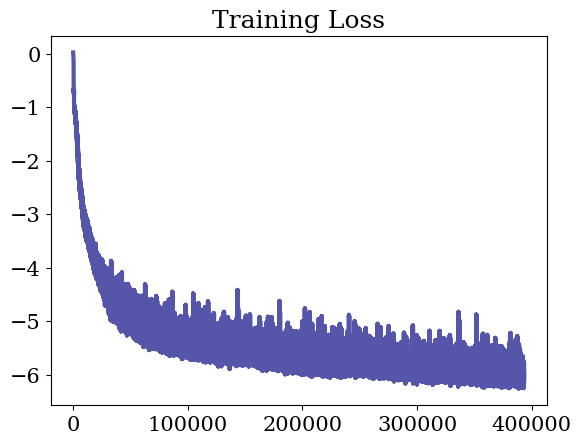

In [ ]:
# we investigate the loss function
plt.plot(jnp.log10(loss_cap),color='navy',alpha=2/3)
plt.title('Training Loss')
plt.show()

Next we generate plots. Since we solve the nested capital-only model, we focus only on the errors in the equilibrium conditions for capital, which are low.

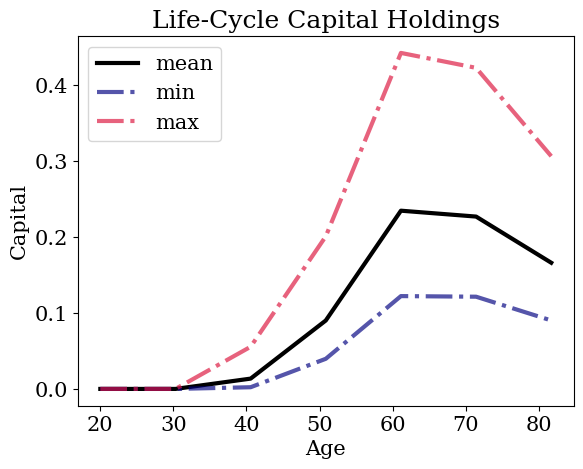

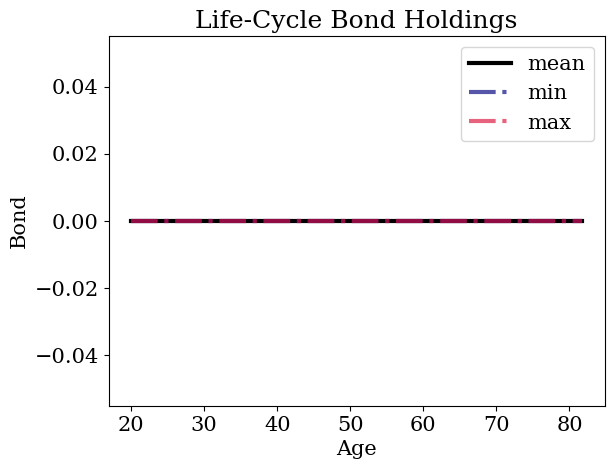

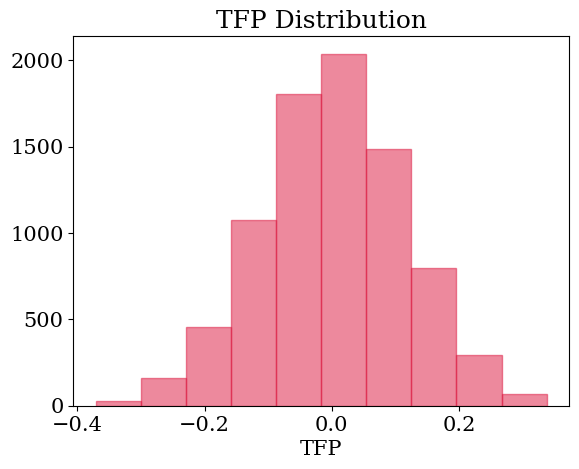

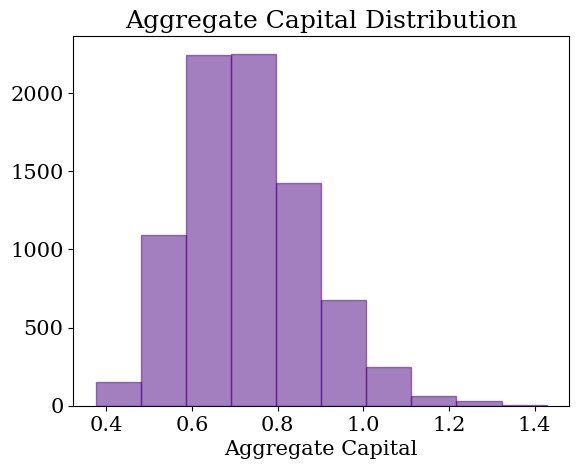

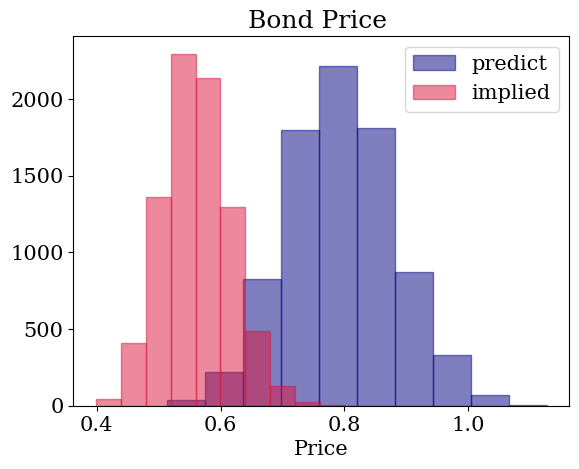

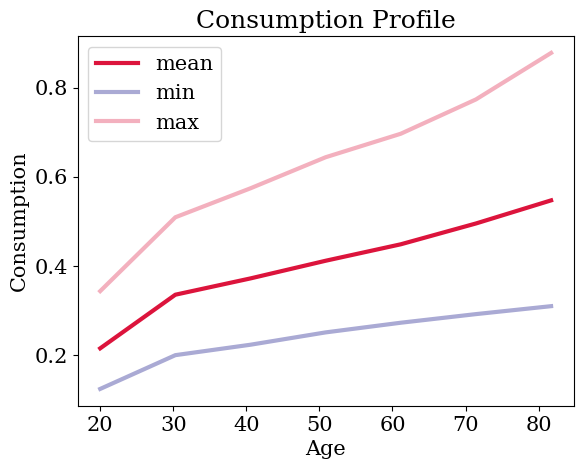

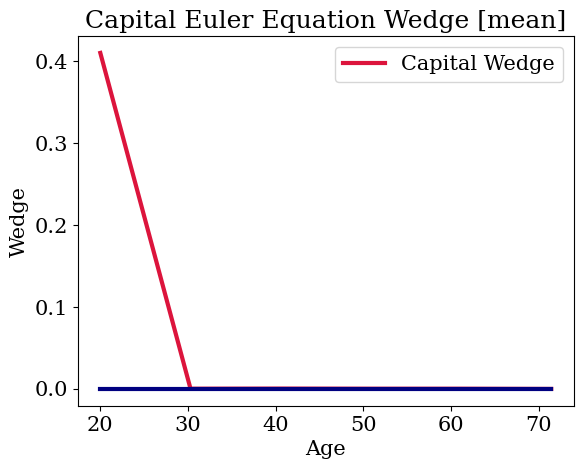

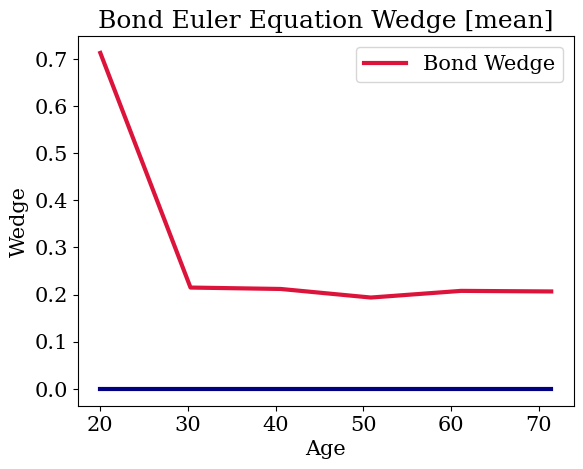

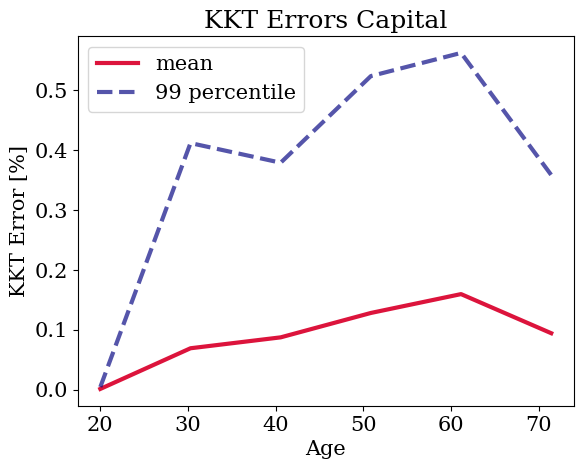

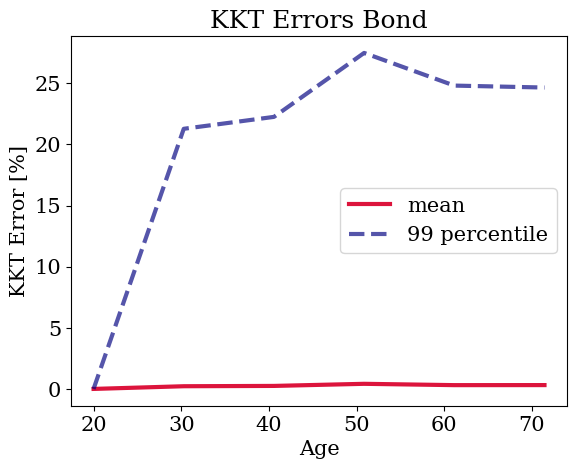

In [ ]:
generate_plots(states_cap, theta_cap, Homotopy_cap)

# Pretrain bond price

Here we turn on the weight on bond pretrain term in loss function to approximate bond price implied by capital only economy.
This helps us to obtain the price implied by the zero-liquidity limit, in which the bond is in zero net-supply and the borrowing constraint remains at zero.
Since we will later slowly lower the borrowing constraint to introduce the bond into the economy, the zero liquidity price is exactly the price we want to start from. For more insights on the zero-liquidity limit in a heterogeneous agents setting, we recommend [these excellent slides](https://github.com/shade-econ/nber-workshop-2023/blob/main/Lectures/Lecture%204%20Canonical%20HANK%20handout.pdf) by [Ludwig Straub](https://scholar.harvard.edu/straub/home) accompanying the [Sequence-Space Jacobian paper](https://onlinelibrary.wiley.com/doi/full/10.3982/ECTA17434?casa_token=MGVRSE62sGIAAAAA%3AJiqPWzPJjHVqd2me5w8e4nzVccWXHEbuAAWSl71rIcKDJeWS4j4OYTty-b1MgfJEJW0PM-gWa_0ODPGOuA) (see [here](https://github.com/shade-econ) for the library). In difference to the blazingly fast [Sequence-Space Jacobian method](https://onlinelibrary.wiley.com/doi/full/10.3982/ECTA17434?casa_token=MGVRSE62sGIAAAAA%3AJiqPWzPJjHVqd2me5w8e4nzVccWXHEbuAAWSl71rIcKDJeWS4j4OYTty-b1MgfJEJW0PM-gWa_0ODPGOuA), our method does not linearize with respect to aggregate risk.

In [ ]:
pre_key = jax.random.split(cap_key,num=2)[1,:]

In [ ]:
Homotopy_pre = copy.deepcopy(Homotopy_cap)

In [ ]:
Homotopy_pre = Homotopy_pre.at[idx_h_b_pre].set(1.0)

In [ ]:
theta_pre, states_pre, loss_pre, opt_state_pre = CloudMethod(cloud_steps_cap, pre_key, states_cap, Gamma, theta_cap, Homotopy_pre, shock_mult, opt_state_cap)

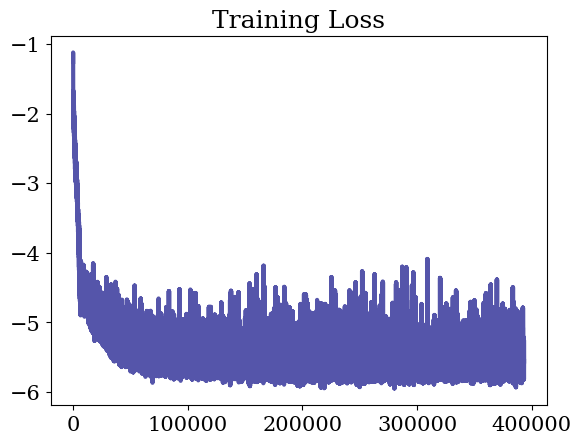

In [ ]:
plt.plot(jnp.log10(loss_pre),color='navy',alpha=2/3)
plt.title('Training Loss')
plt.show()

In the following plots, note the plot titled "Bond Euler Equation Wedge". The bond Euler equation is now fulfilled for exactly one age-group, namely the "most constrained" household, who would be the first to purchase an infinitesimal bond supply, when it is introduced into the economy.

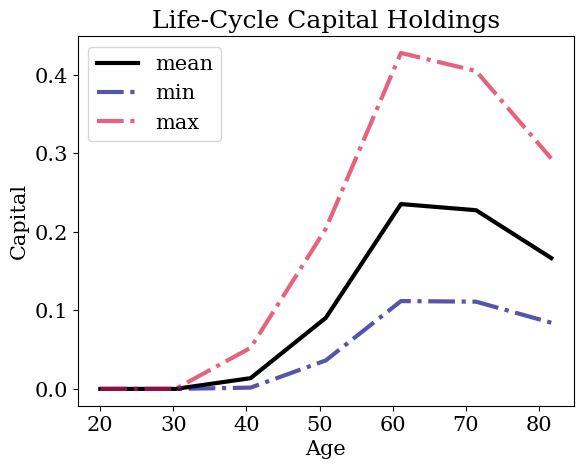

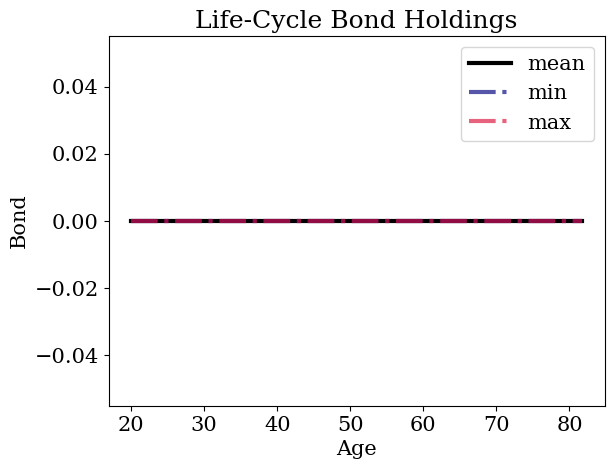

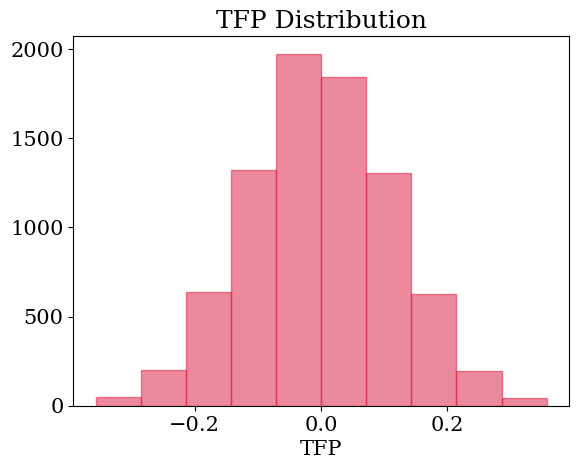

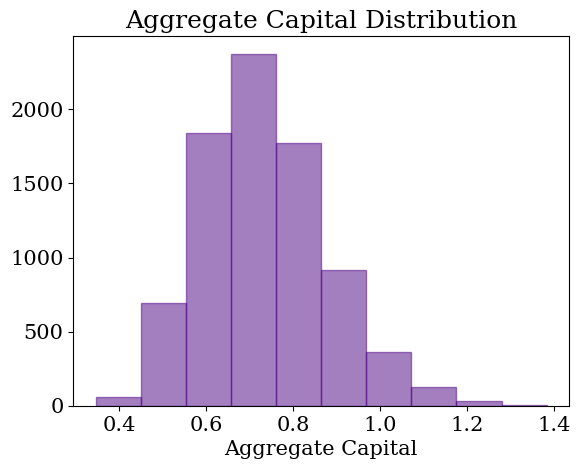

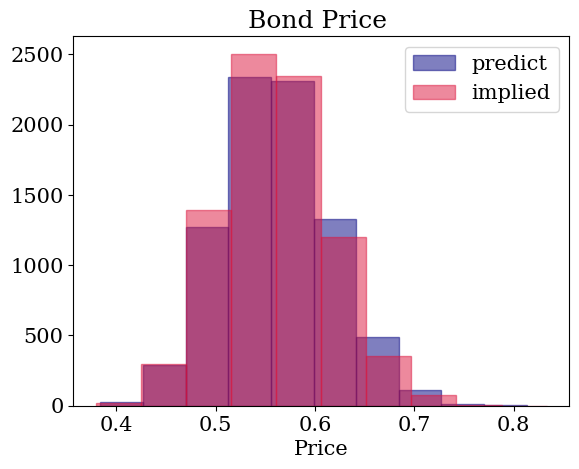

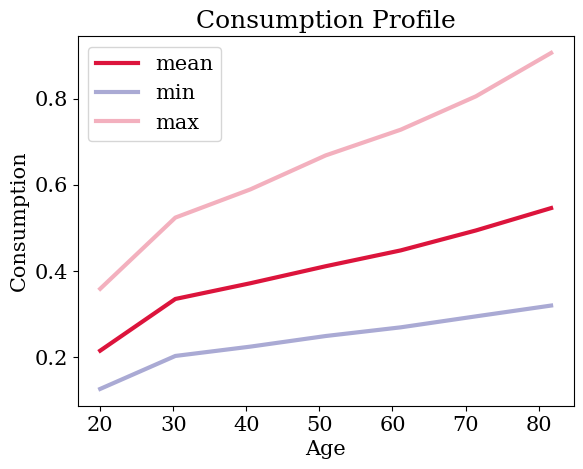

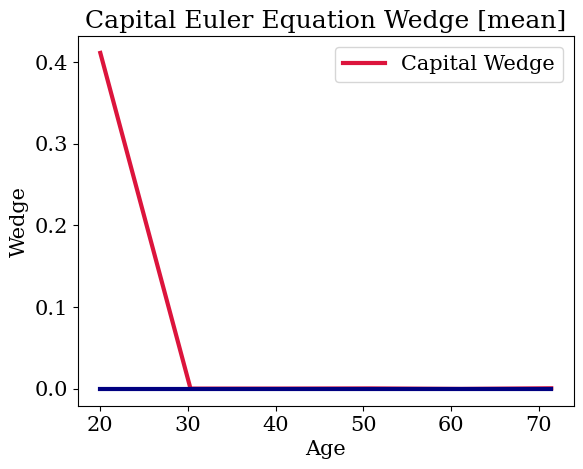

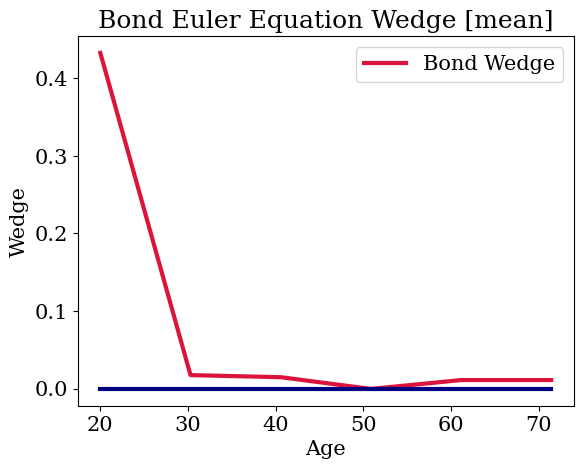

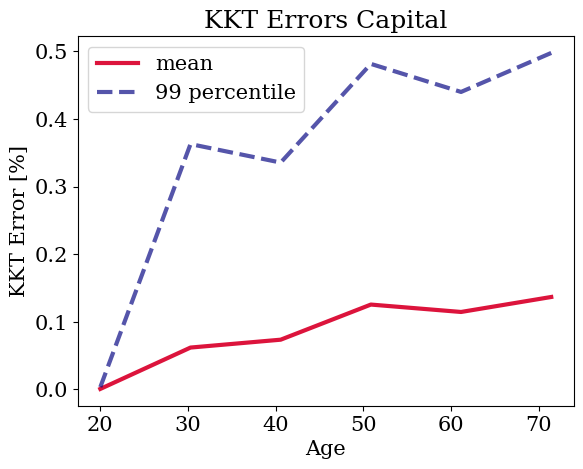

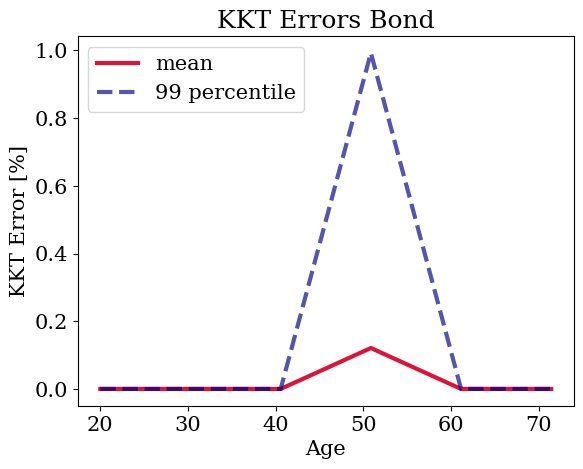

In [ ]:
generate_plots(states_pre, theta_pre, Homotopy_pre)

# Bond Homotopy

## First step
We now introduce a small amount by bond trading by relaxing borrowing constraint and train untill convergence.

In [ ]:
first_key = jax.random.split(pre_key,num=2)[1,:]

In [ ]:
states_first = copy.deepcopy(states_pre)
theta_first = copy.deepcopy(theta_pre)
opt_state_first = copy.deepcopy(opt_state_pre)

In [ ]:
Homotopy_first = copy.deepcopy(Homotopy_pre)

# Change weight on bond euler equation from 0 to 1 (add bond euler equation into loss function)
Homotopy_first = Homotopy_first.at[idx_h_b_wgh].set(1.0)

# Change weight on bond price pretrain from 1 to 0 (drop bond pretraining error from loss function)
Homotopy_first = Homotopy_first.at[idx_h_b_pre].set(0.0)

# Change bond policy mask from 0 to 0.01 (allow non-zero bond allocations, but shrink initial guess towards zero)
Homotopy_first = Homotopy_first.at[idx_h_b_msk].set(0.1)

# Relax borrowing constraint a bit to allow bond trading
b_min_first_target = b_min_target/(N_cohort-1)
Homotopy_first = Homotopy_first.at[idx_h_b_min].set(b_min_first_target)

cloud_steps_first = 2048

In [ ]:
# function call takes about 4 minutes on a T4 GPU
theta_first, states_first, loss_first, opt_state_first = CloudMethod(cloud_steps_first, first_key, states_pre, Gamma, theta_pre, Homotopy_first, shock_mult, opt_state_pre)

<ipython-input-24-3a63471830d8>:10: DeprecationWarning: The newshape argument of jax.numpy.reshape is deprecated and setting it will soon raise an error. To avoid an error in the future, and to suppress this warning, please use the shape argument instead.
  loss_field = jnp.reshape(loss_field, newshape = (cloud_steps * steps_epoch,))


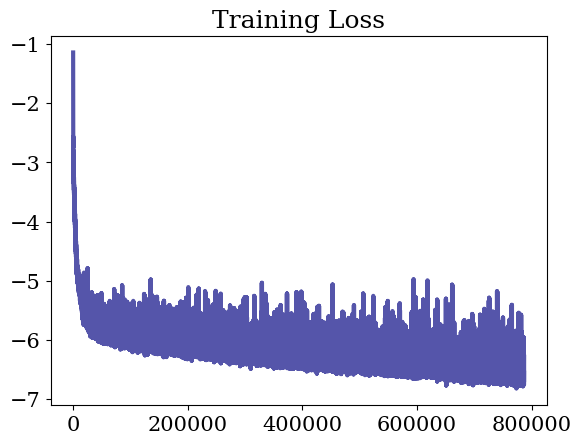

In [ ]:
plt.plot(jnp.log10(loss_first),color='navy',alpha=2/3)
plt.title('Training Loss')
plt.show()

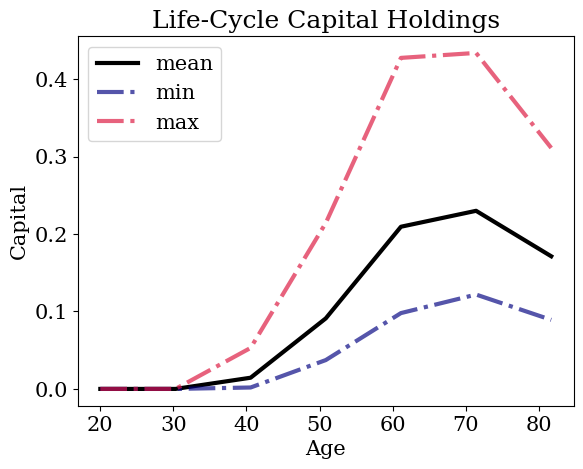

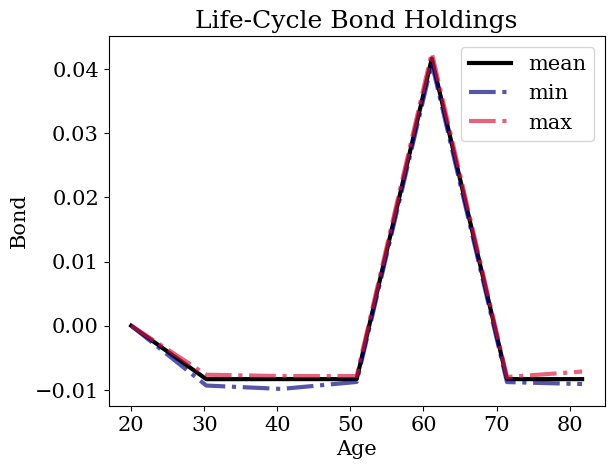

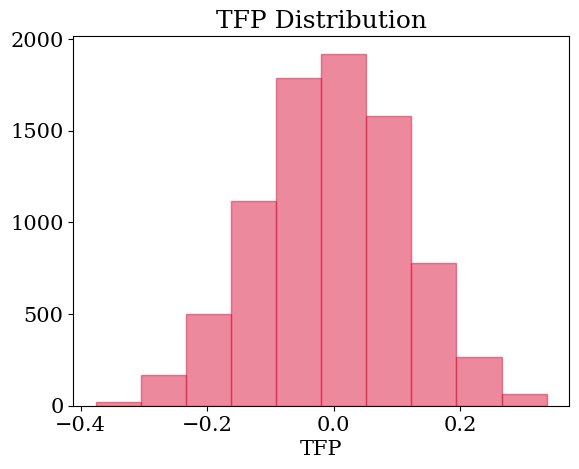

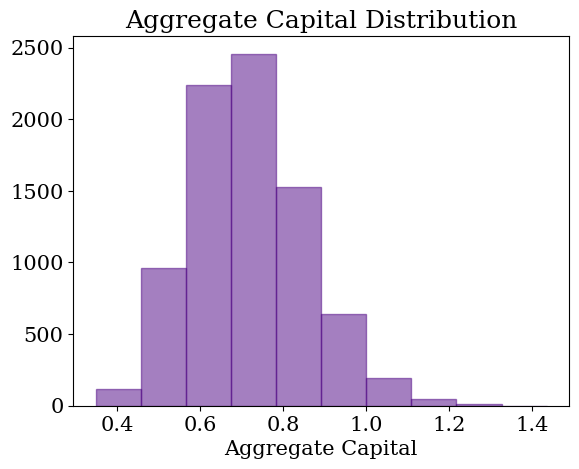

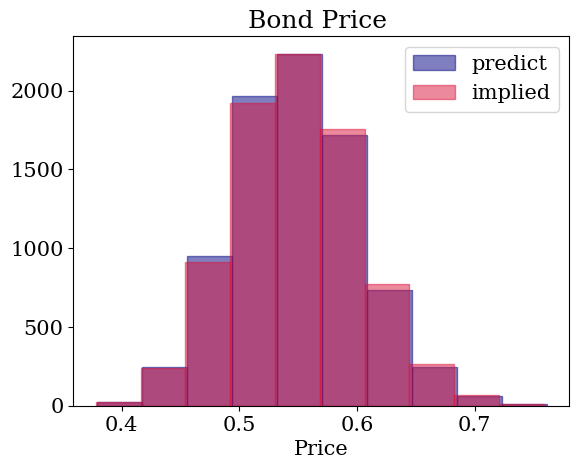

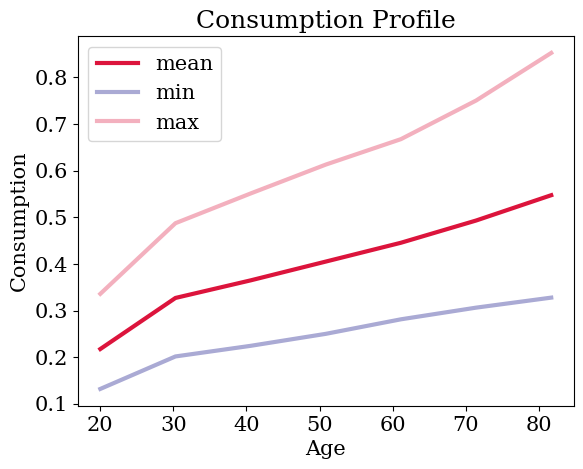

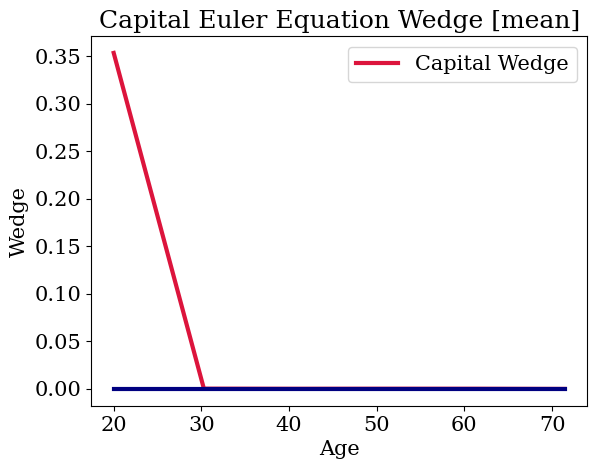

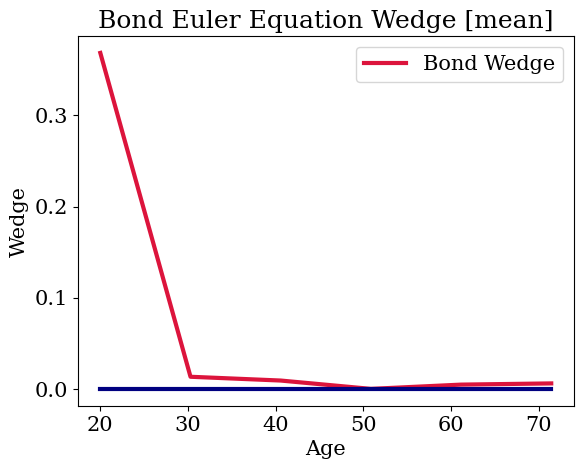

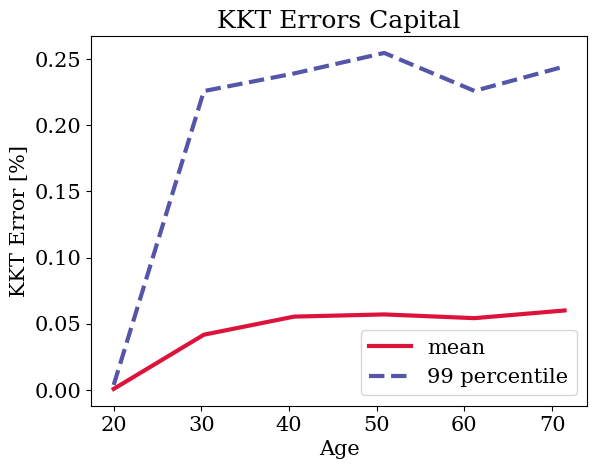

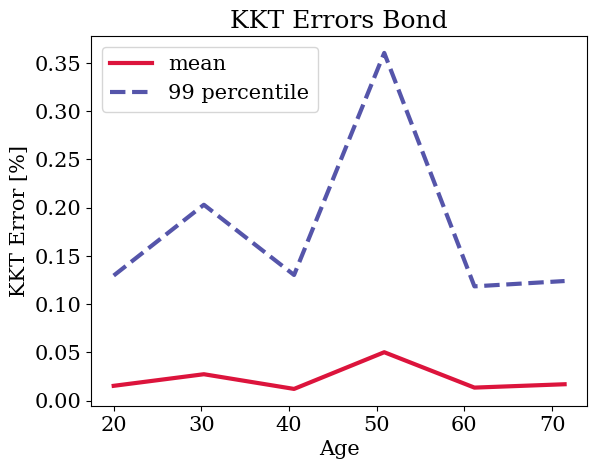

In [ ]:
generate_plots(states_first, theta_first, Homotopy_first)

## Second step
Next we introduce remaining bond trading capacity by step-wise relaxing borrowing constraint in a loop.

In [ ]:
states_second = copy.deepcopy(states_first)
theta_second = copy.deepcopy(theta_first)
opt_state_second = copy.deepcopy(opt_state_first)

Homotopy_second = copy.deepcopy(Homotopy_first)

In [ ]:
homotopy_steps = 4096
steps_per_homotopy = 1

# construct the grid for slowly reducing the borrowing constraint on the bond
b_min_space = jnp.linspace(start=b_min_first_target,stop=b_min_target,num=homotopy_steps)

In [ ]:
second_key = jax.random.split(first_key,num=homotopy_steps)

x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 0 of 4096
Bond supply: -0.008333334


<ipython-input-24-3a63471830d8>:10: DeprecationWarning: The newshape argument of jax.numpy.reshape is deprecated and setting it will soon raise an error. To avoid an error in the future, and to suppress this warning, please use the shape argument instead.
  loss_field = jnp.reshape(loss_field, newshape = (cloud_steps * steps_epoch,))


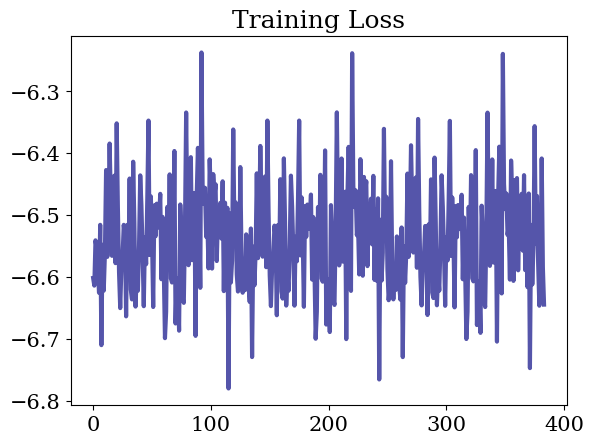

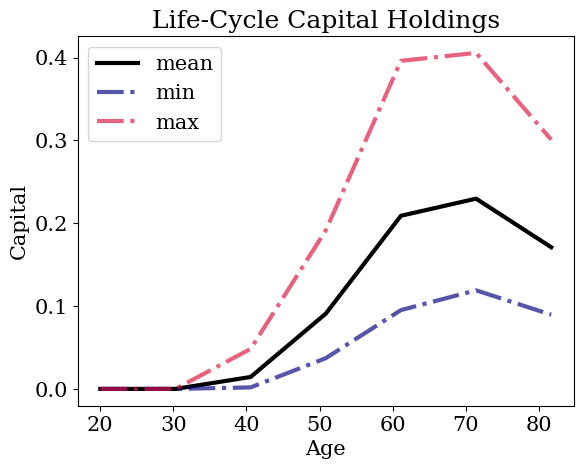

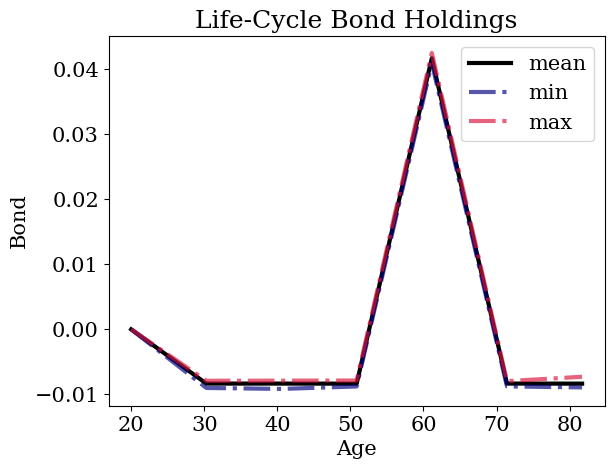

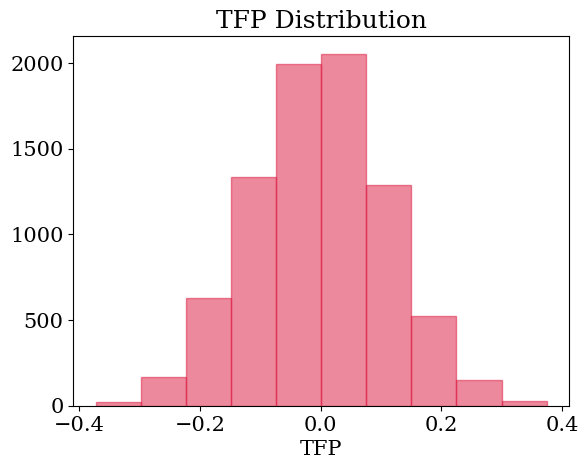

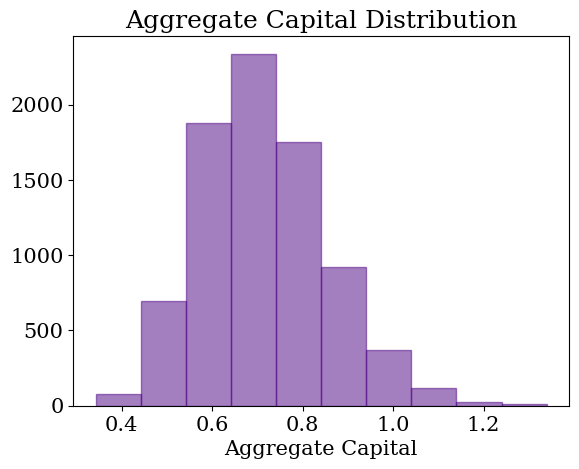

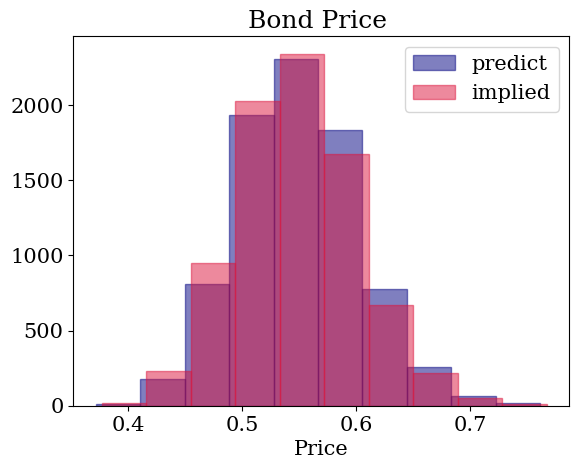

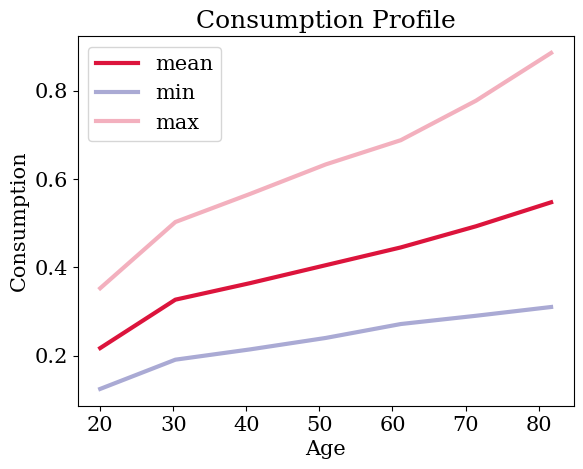

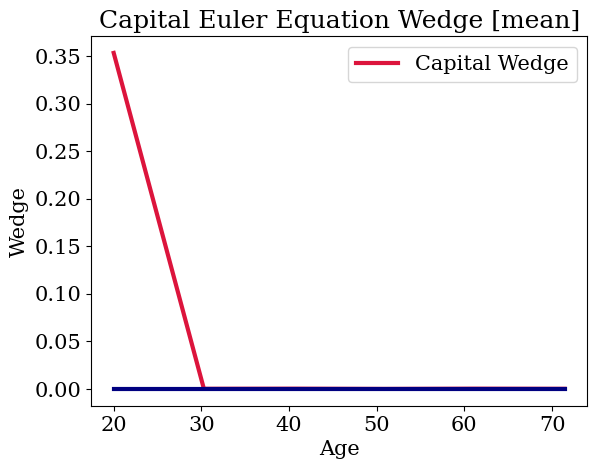

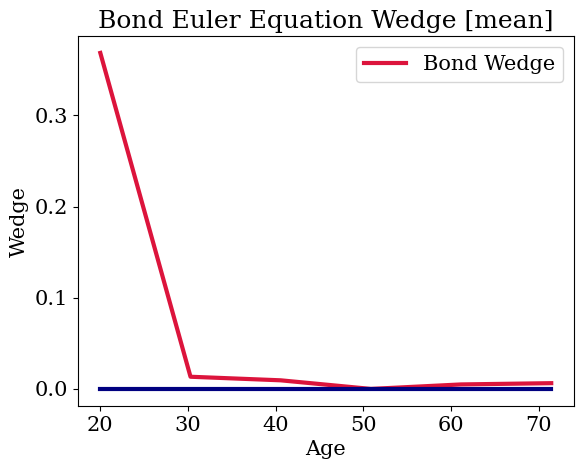

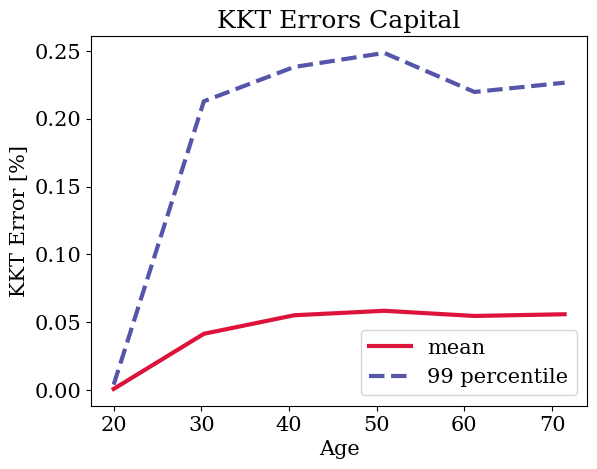

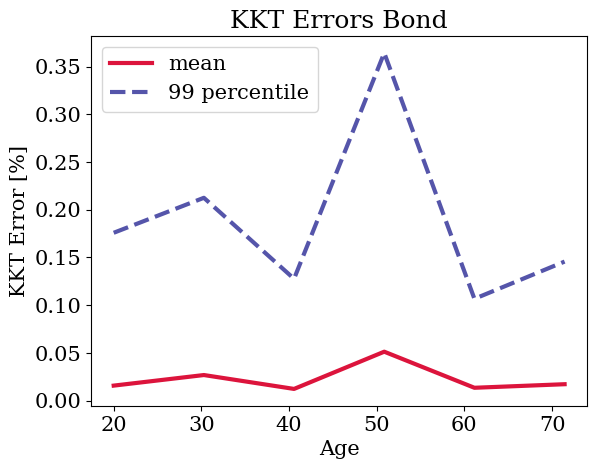

x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 40 of 4096
Bond supply: -0.008740334
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 80 of 4096
Bond supply: -0.009147335
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 120 of 4096
Bond supply: -0.009554335
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 160 of 4096
Bond supply: -0.009961335
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 200 of 4096
Bond supply: -0.010368336


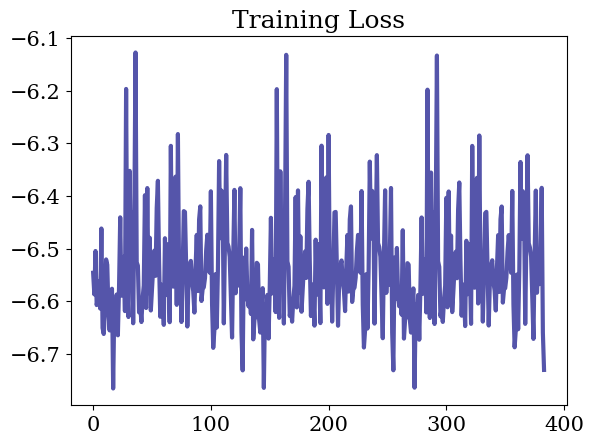

x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 240 of 4096
Bond supply: -0.010775336
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 280 of 4096
Bond supply: -0.011182337
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 320 of 4096
Bond supply: -0.011589337
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 360 of 4096
Bond supply: -0.011996338
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 400 of 4096
Bond supply: -0.012403338


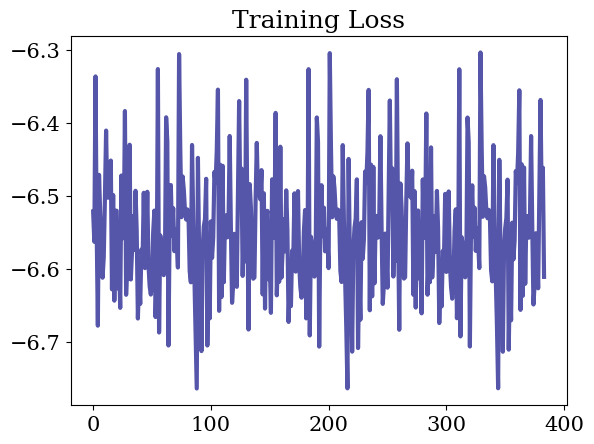

x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 440 of 4096
Bond supply: -0.012810338
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 480 of 4096
Bond supply: -0.013217339
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 520 of 4096
Bond supply: -0.013624339
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 560 of 4096
Bond supply: -0.014031339
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 600 of 4096
Bond supply: -0.01443834


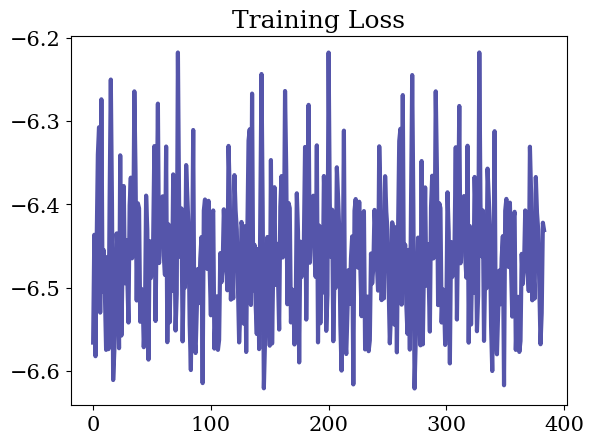

x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 640 of 4096
Bond supply: -0.014845341
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 680 of 4096
Bond supply: -0.015252341
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 720 of 4096
Bond supply: -0.015659342
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 760 of 4096
Bond supply: -0.016066343
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 800 of 4096
Bond supply: -0.016473342


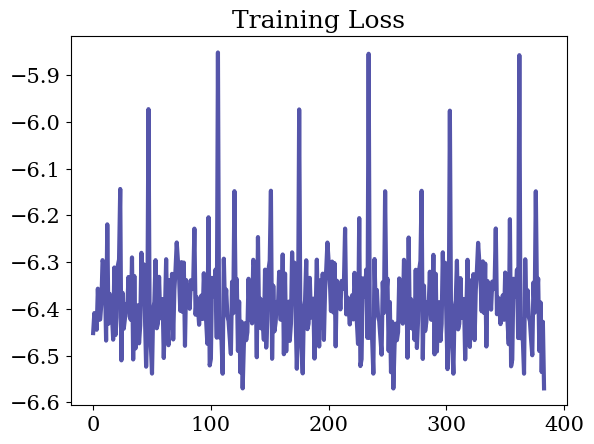

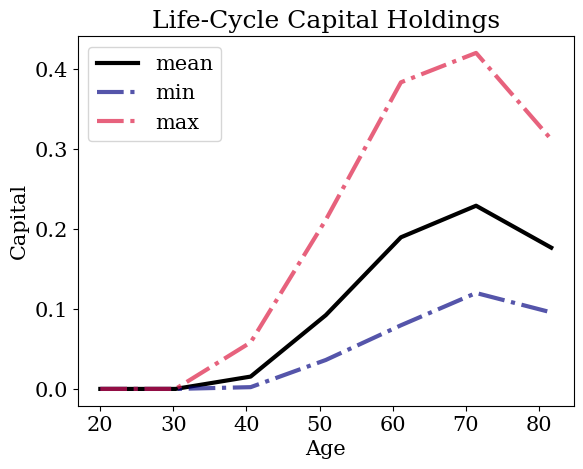

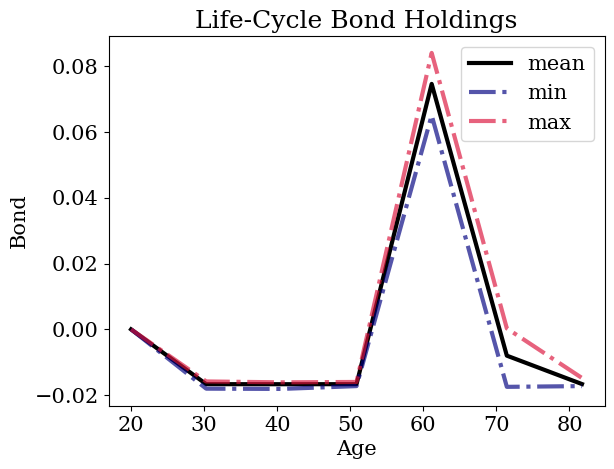

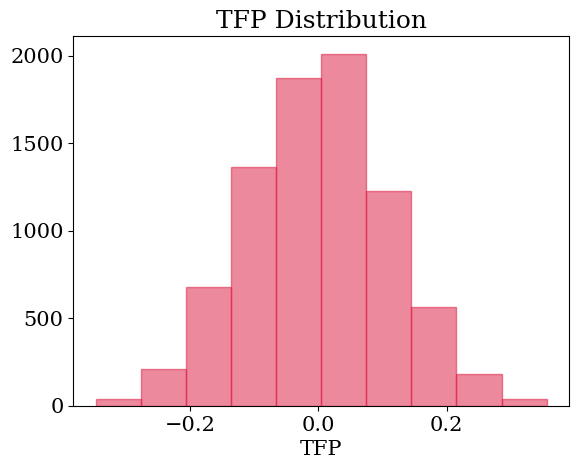

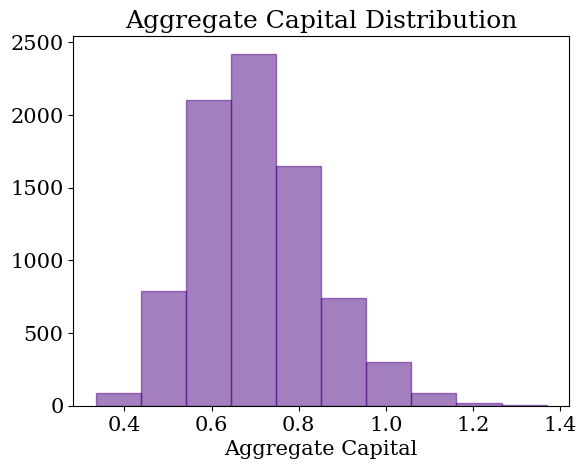

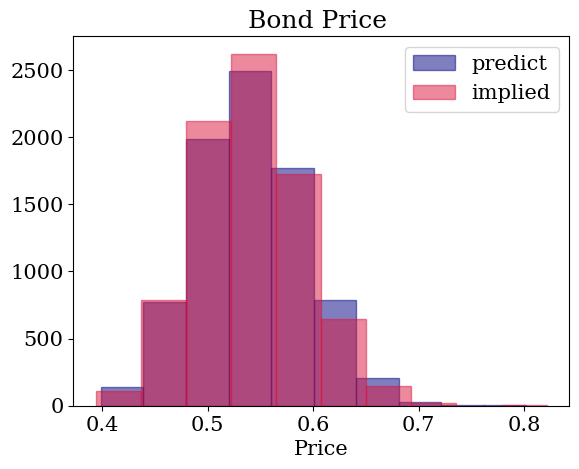

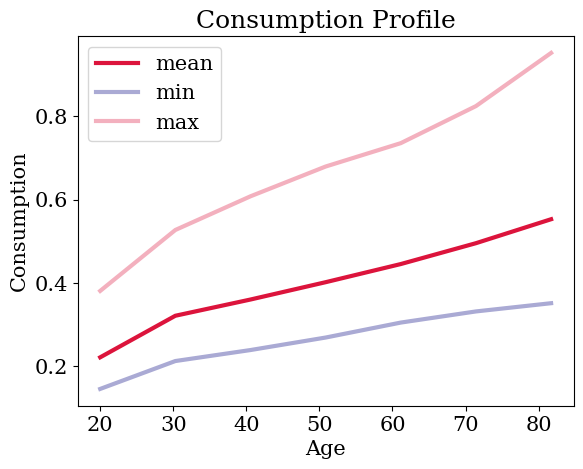

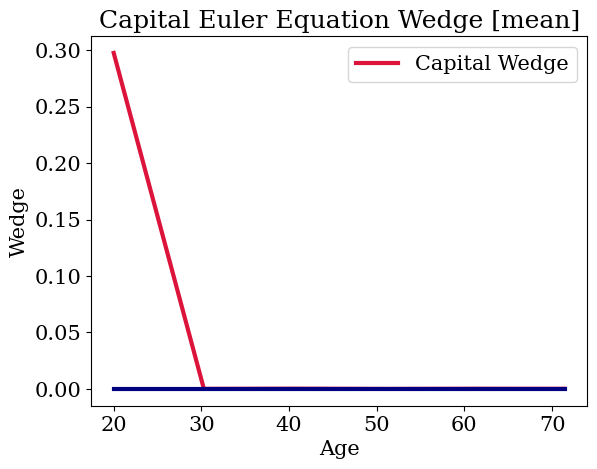

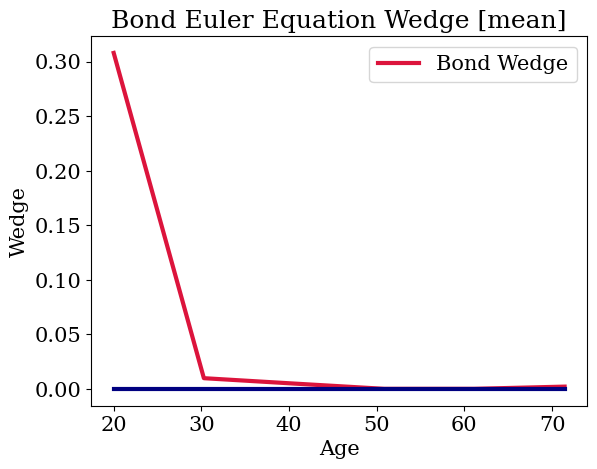

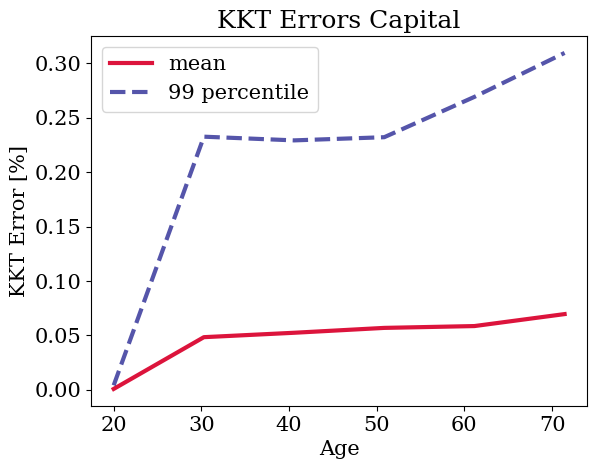

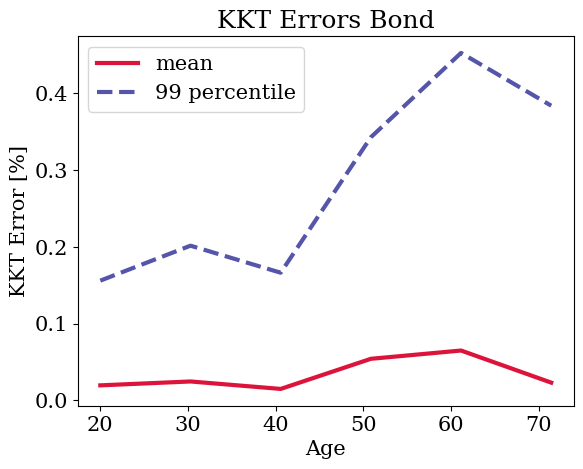

x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 840 of 4096
Bond supply: -0.016880343
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 880 of 4096
Bond supply: -0.017287344
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 920 of 4096
Bond supply: -0.017694343
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 960 of 4096
Bond supply: -0.018101344
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 1000 of 4096
Bond supply: -0.018508345


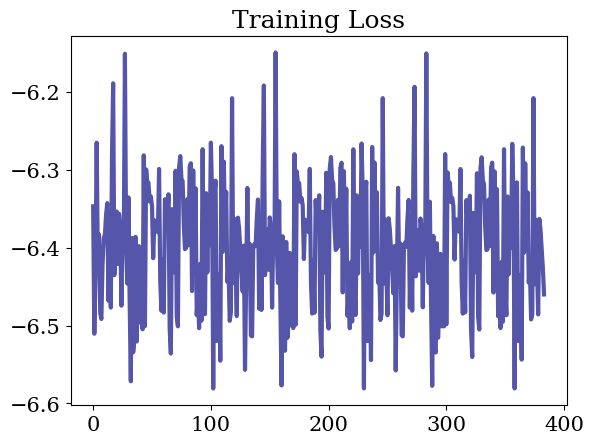

x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 1040 of 4096
Bond supply: -0.018915344
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 1080 of 4096
Bond supply: -0.019322345
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 1120 of 4096
Bond supply: -0.019729346
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 1160 of 4096
Bond supply: -0.020136347
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 1200 of 4096
Bond supply: -0.020543348


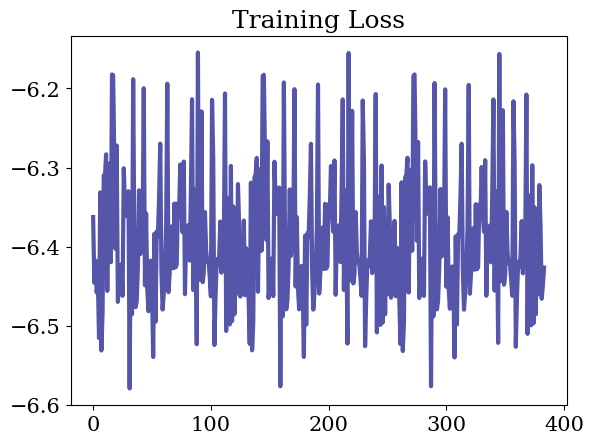

x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 1240 of 4096
Bond supply: -0.020950347
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 1280 of 4096
Bond supply: -0.021357348
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 1320 of 4096
Bond supply: -0.02176435
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 1360 of 4096
Bond supply: -0.022171348
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 1400 of 4096
Bond supply: -0.02257835


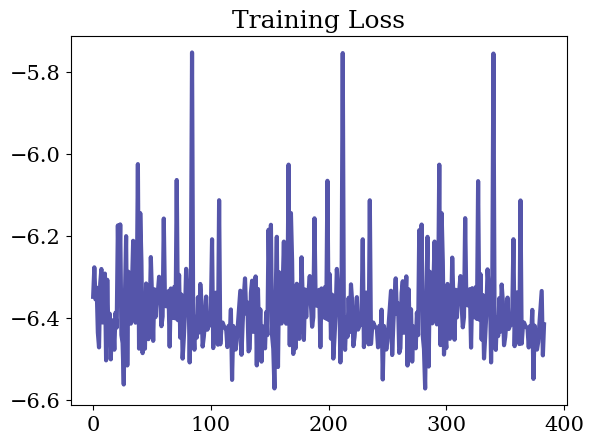

x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 1440 of 4096
Bond supply: -0.02298535
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 1480 of 4096
Bond supply: -0.02339235
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 1520 of 4096
Bond supply: -0.02379935
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 1560 of 4096
Bond supply: -0.02420635
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 1600 of 4096
Bond supply: -0.02461335


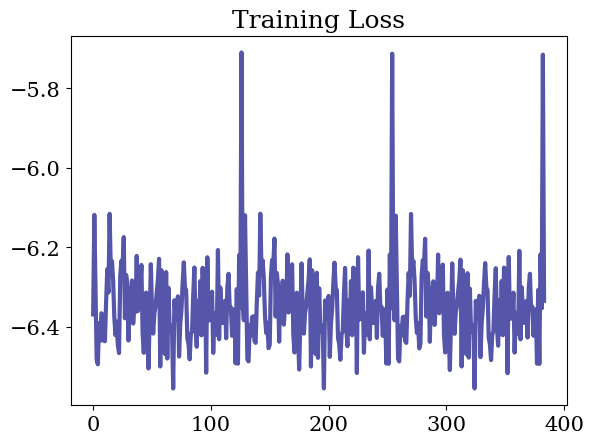

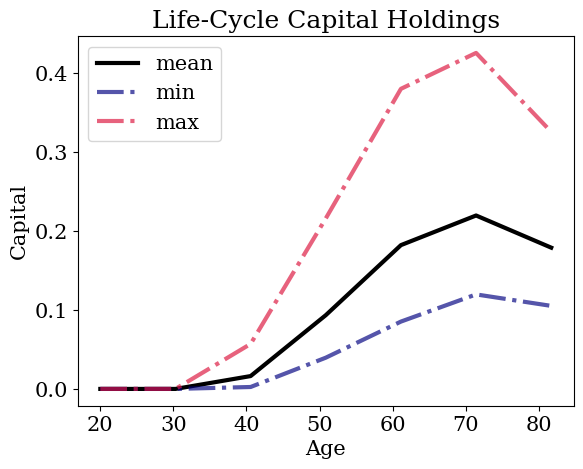

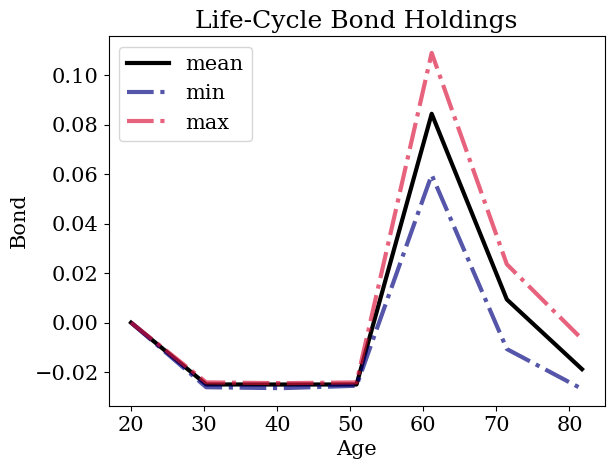

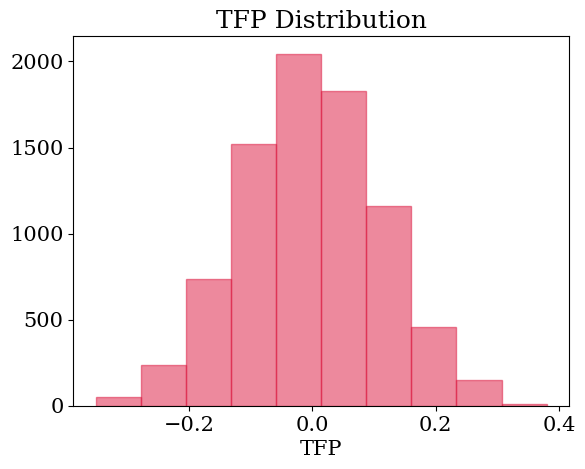

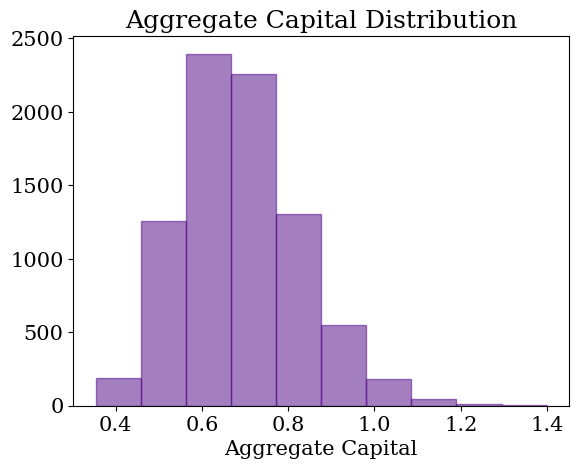

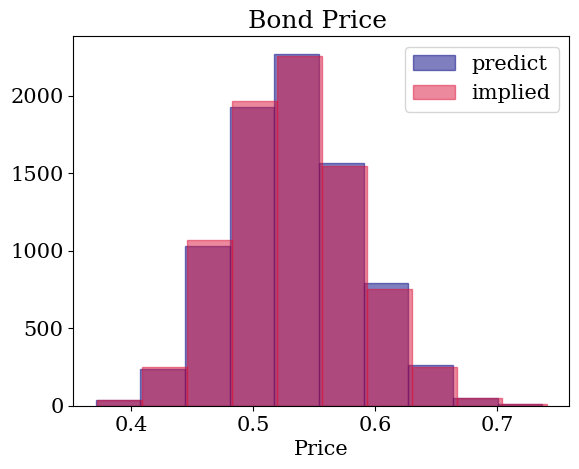

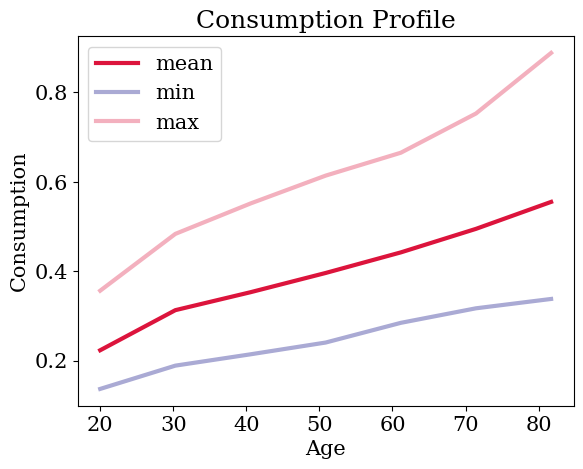

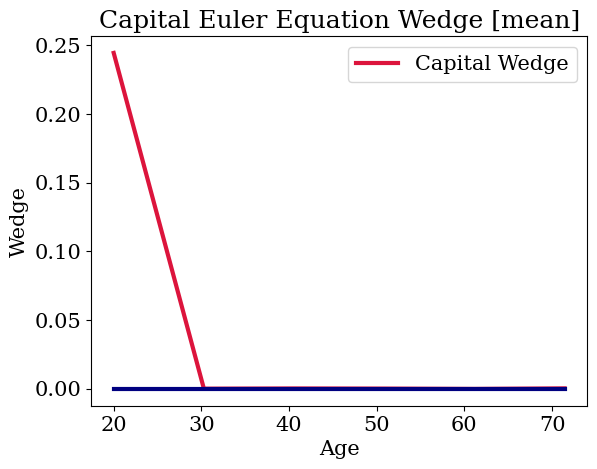

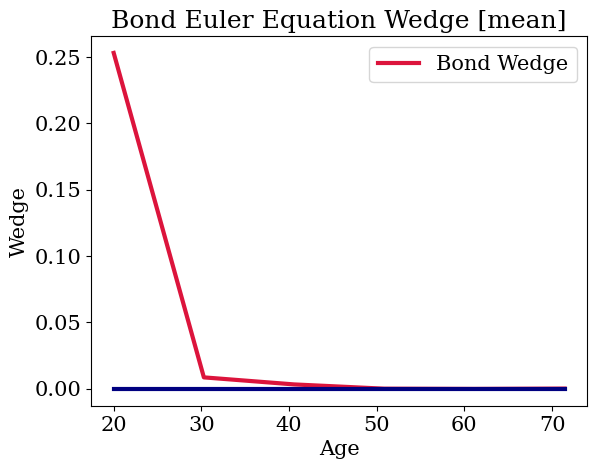

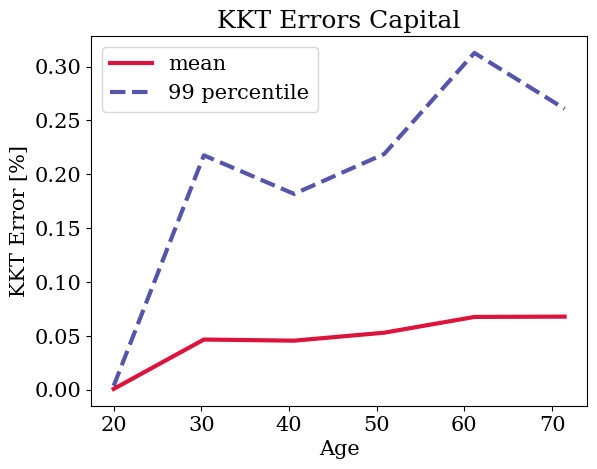

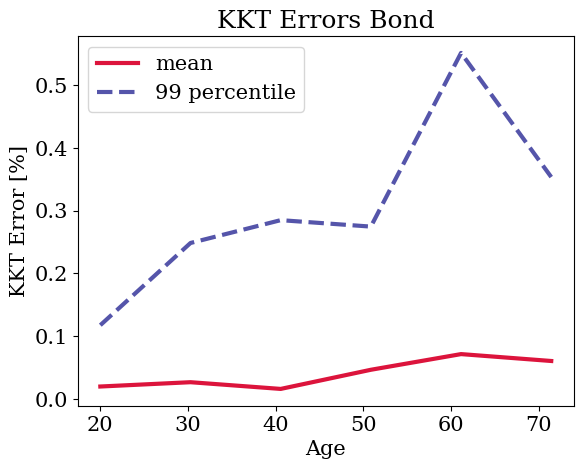

x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 1640 of 4096
Bond supply: -0.02502035
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 1680 of 4096
Bond supply: -0.02542735
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 1720 of 4096
Bond supply: -0.025834352
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 1760 of 4096
Bond supply: -0.02624135
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 1800 of 4096
Bond supply: -0.026648352


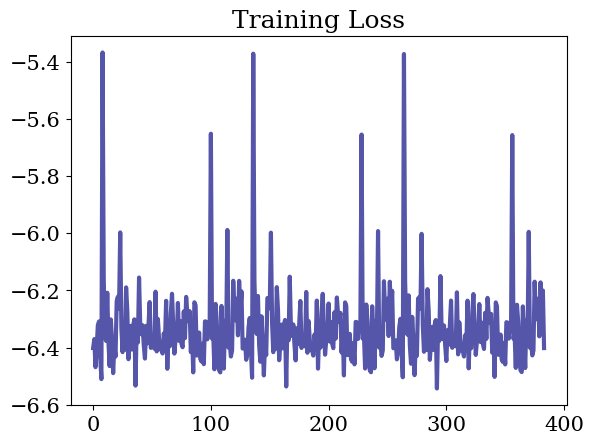

x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 1840 of 4096
Bond supply: -0.027055353
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 1880 of 4096
Bond supply: -0.027462352
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 1920 of 4096
Bond supply: -0.027869353
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 1960 of 4096
Bond supply: -0.028276354
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 2000 of 4096
Bond supply: -0.028683353
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 2040 of 4096
Bond supply: -0.029090354


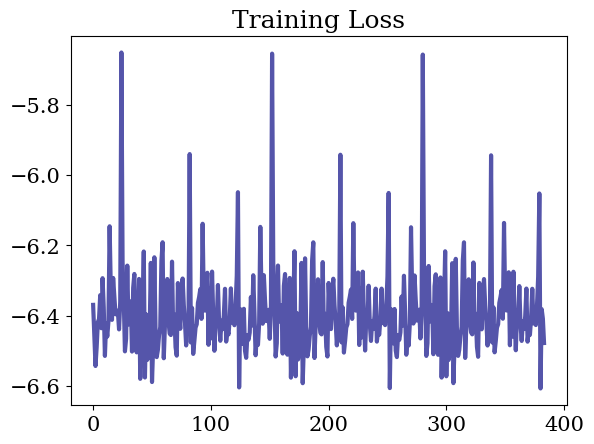

x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 2080 of 4096
Bond supply: -0.029497355
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 2120 of 4096
Bond supply: -0.029904354
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 2160 of 4096
Bond supply: -0.030311355
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 2200 of 4096
Bond supply: -0.030718358
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 2240 of 4096
Bond supply: -0.03112536


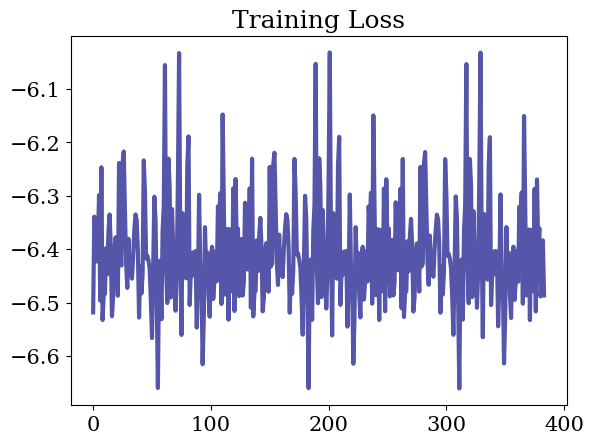

x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 2280 of 4096
Bond supply: -0.03153236
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 2320 of 4096
Bond supply: -0.031939358
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 2360 of 4096
Bond supply: -0.03234636
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 2400 of 4096
Bond supply: -0.03275336
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 2440 of 4096
Bond supply: -0.03316036


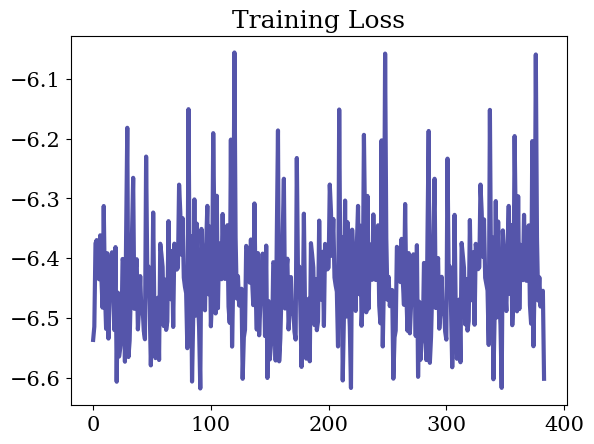

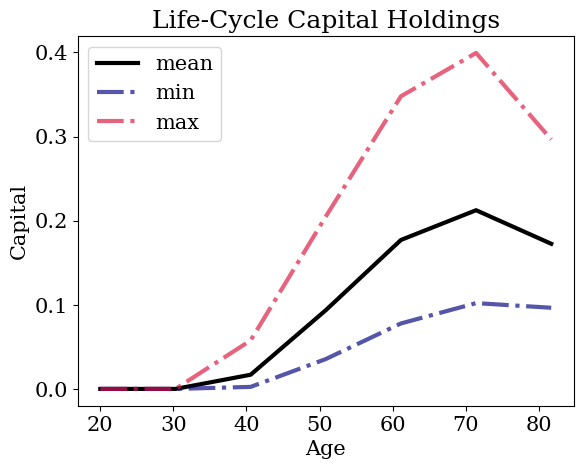

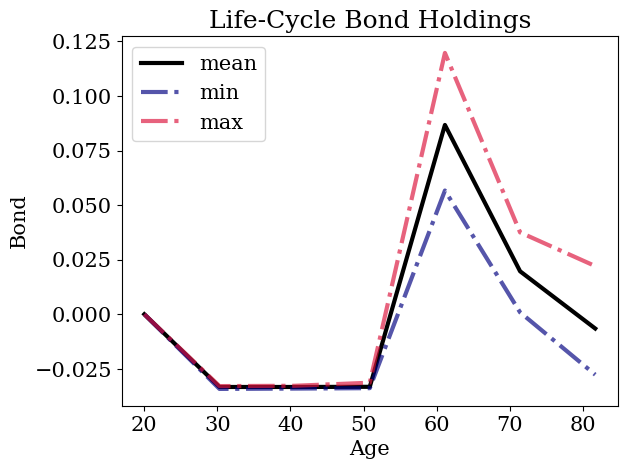

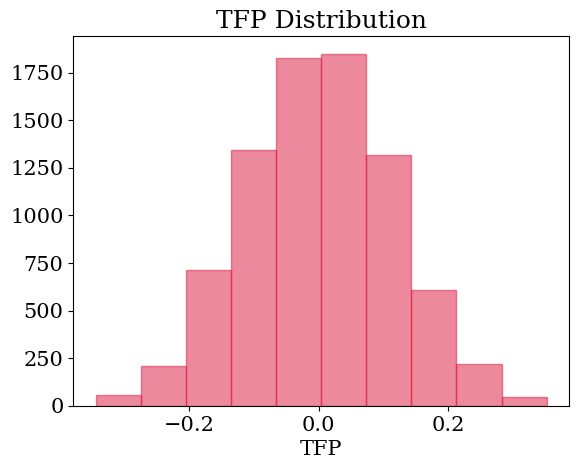

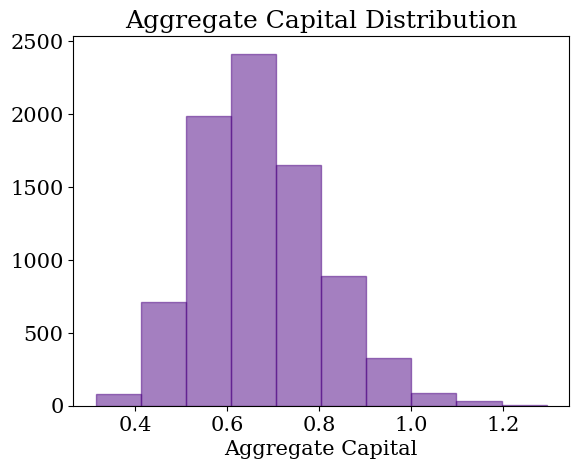

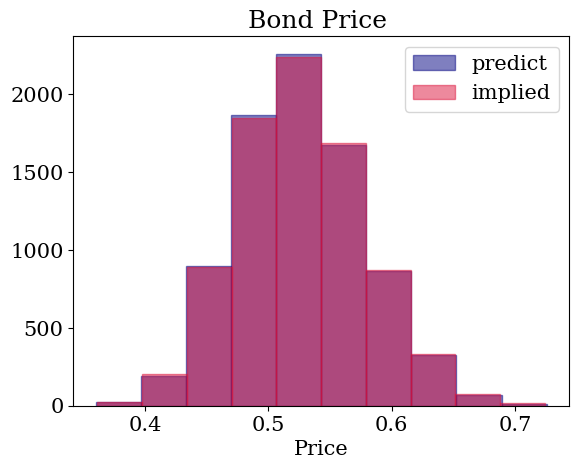

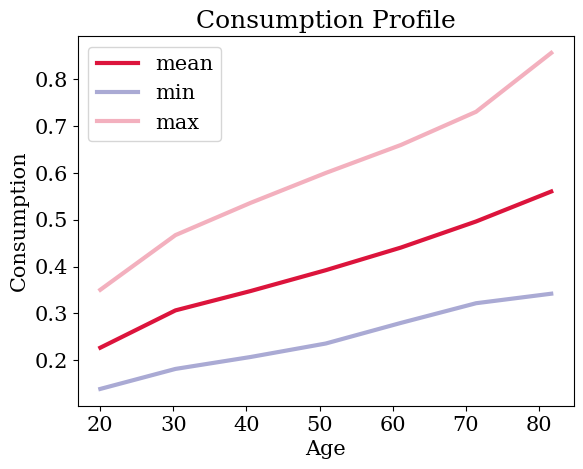

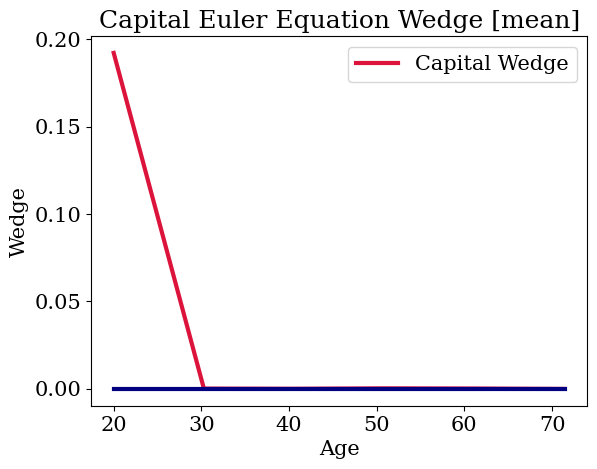

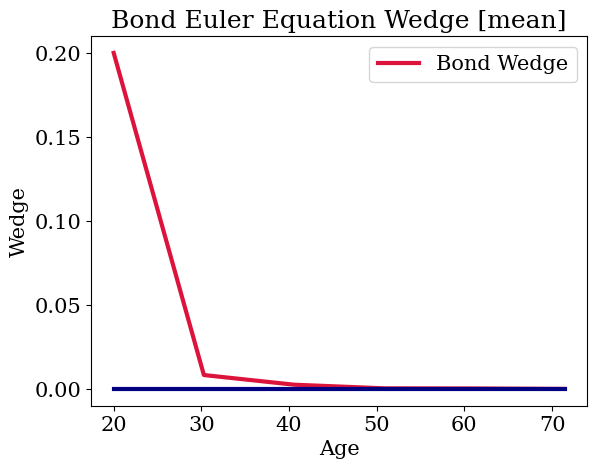

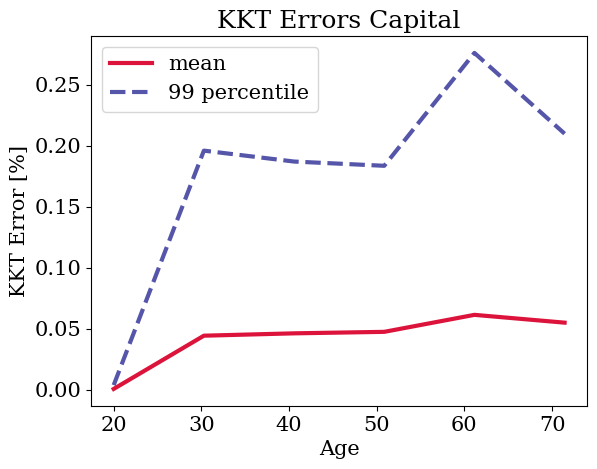

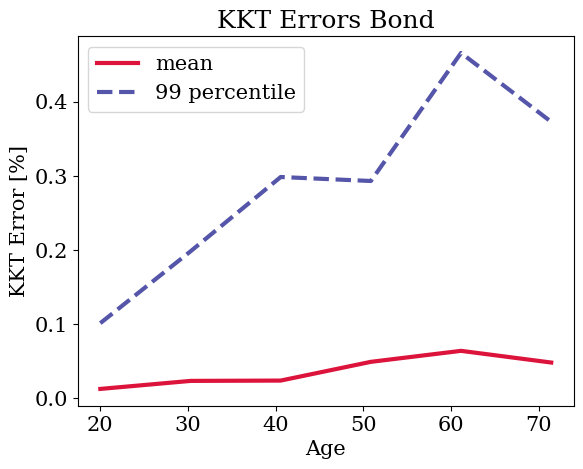

x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 2480 of 4096
Bond supply: -0.03356736
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 2520 of 4096
Bond supply: -0.03397436
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 2560 of 4096
Bond supply: -0.03438136
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 2600 of 4096
Bond supply: -0.034788363
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 2640 of 4096
Bond supply: -0.03519536


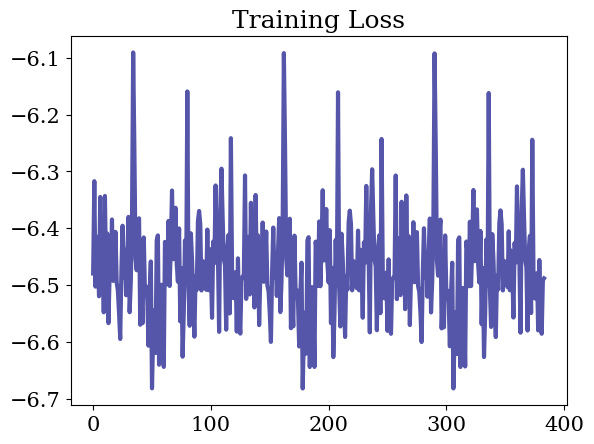

x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 2680 of 4096
Bond supply: -0.03560236
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 2720 of 4096
Bond supply: -0.036009364
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 2760 of 4096
Bond supply: -0.036416363
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 2800 of 4096
Bond supply: -0.036823362
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 2840 of 4096
Bond supply: -0.037230365


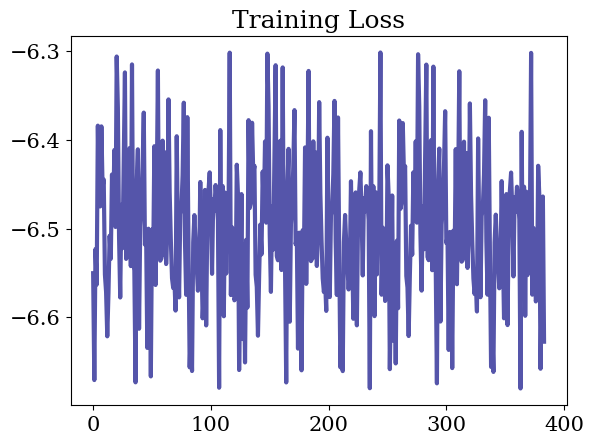

x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 2880 of 4096
Bond supply: -0.037637364
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 2920 of 4096
Bond supply: -0.038044363
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 2960 of 4096
Bond supply: -0.038451366
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 3000 of 4096
Bond supply: -0.038858365
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 3040 of 4096
Bond supply: -0.039265364


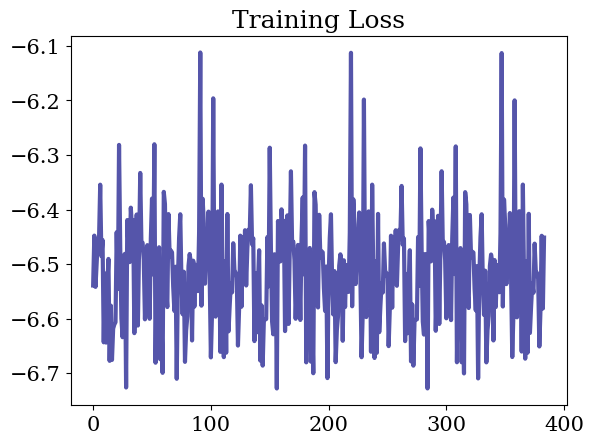

x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 3080 of 4096
Bond supply: -0.039672367
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 3120 of 4096
Bond supply: -0.040079366
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 3160 of 4096
Bond supply: -0.040486366
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 3200 of 4096
Bond supply: -0.04089337
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 3240 of 4096
Bond supply: -0.041300368


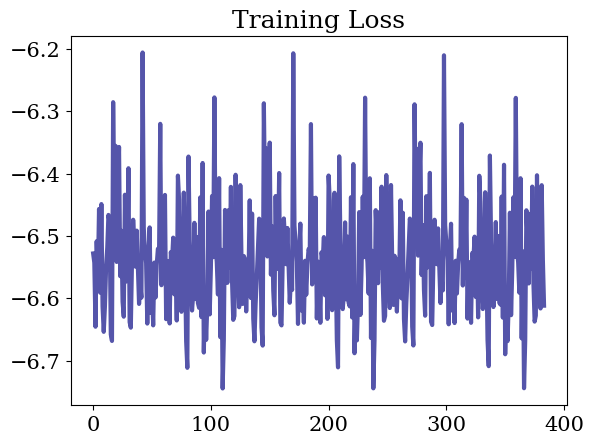

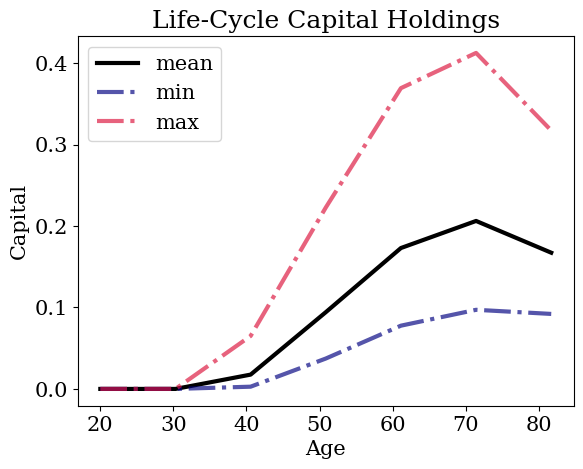

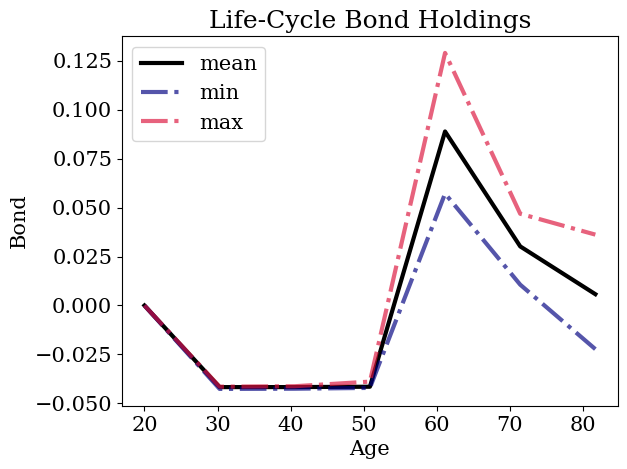

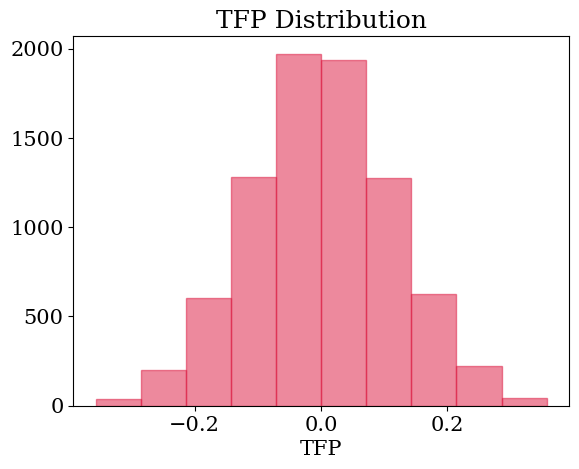

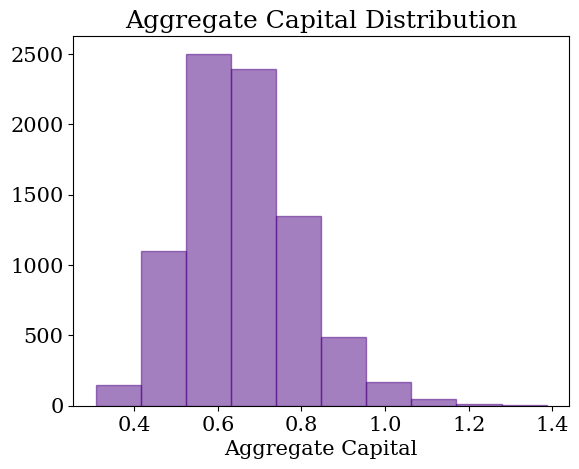

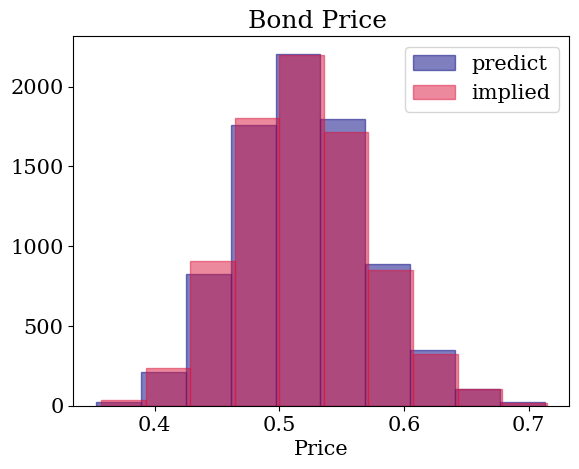

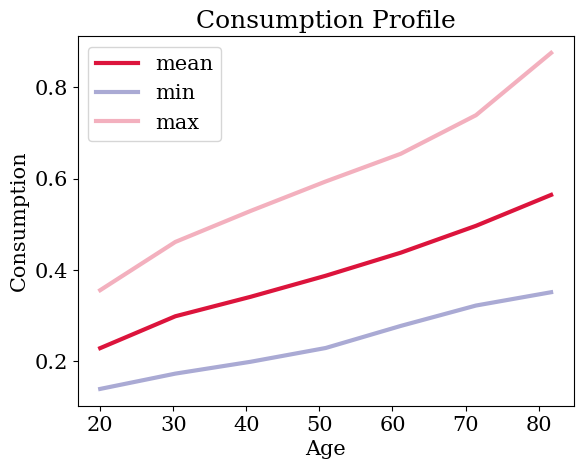

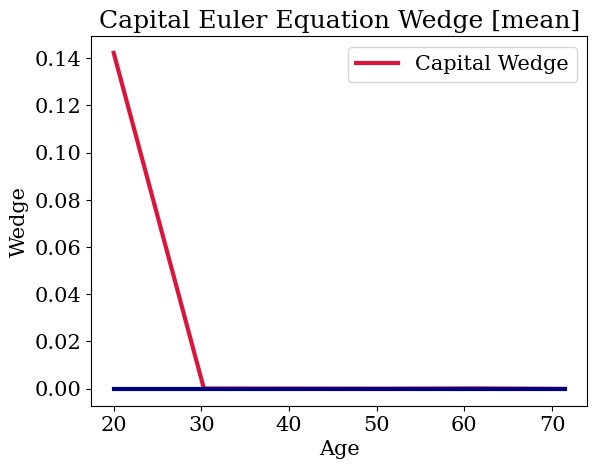

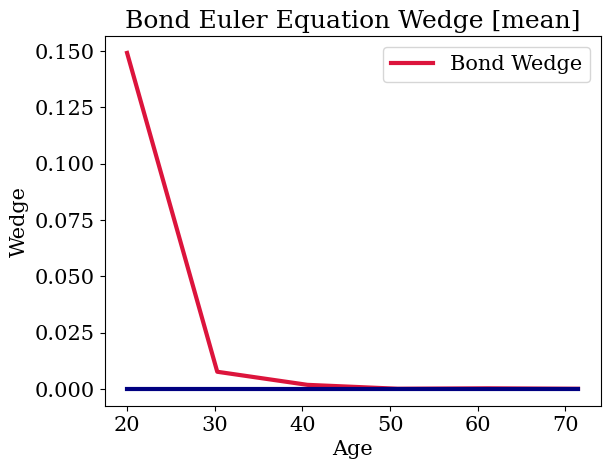

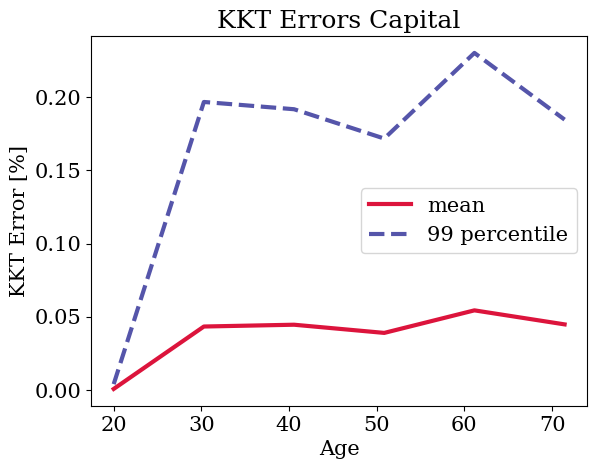

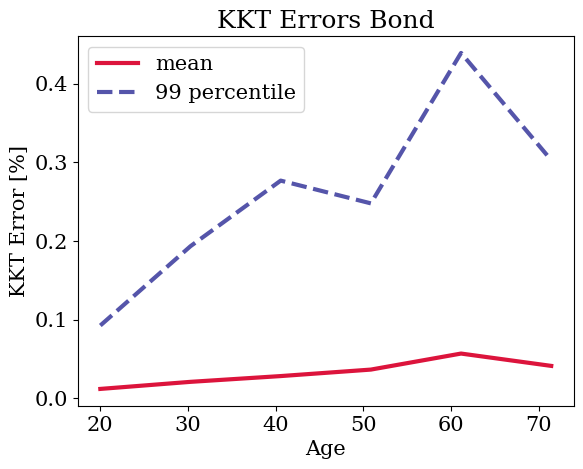

x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 3280 of 4096
Bond supply: -0.041707367
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 3320 of 4096
Bond supply: -0.04211437
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 3360 of 4096
Bond supply: -0.04252137
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 3400 of 4096
Bond supply: -0.042928368
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 3440 of 4096
Bond supply: -0.04333537


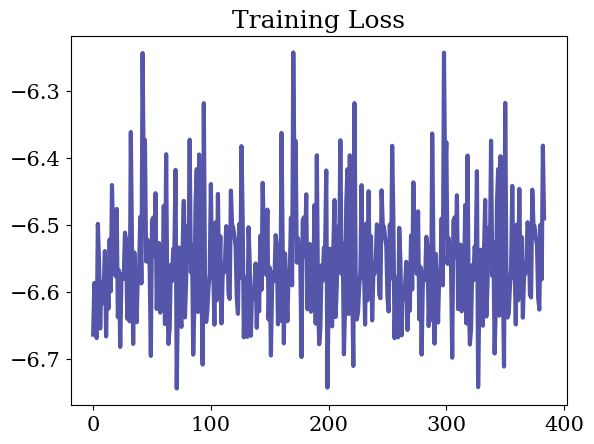

x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 3480 of 4096
Bond supply: -0.04374237
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 3520 of 4096
Bond supply: -0.04414937
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 3560 of 4096
Bond supply: -0.044556372
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 3600 of 4096
Bond supply: -0.04496337
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 3640 of 4096
Bond supply: -0.04537037


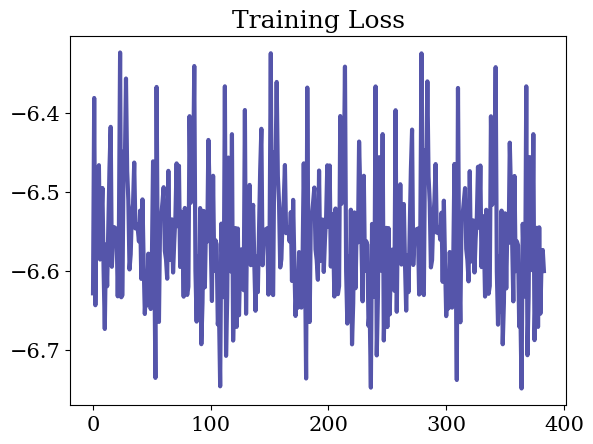

x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 3680 of 4096
Bond supply: -0.045777373
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 3720 of 4096
Bond supply: -0.046184372
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 3760 of 4096
Bond supply: -0.04659137
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 3800 of 4096
Bond supply: -0.046998374
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 3840 of 4096
Bond supply: -0.047405373


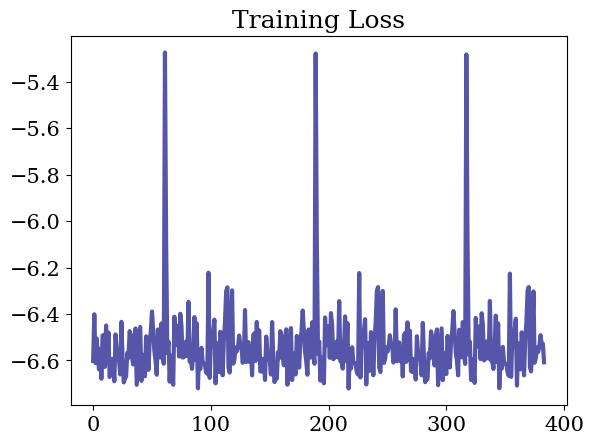

x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 3880 of 4096
Bond supply: -0.047812372
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 3920 of 4096
Bond supply: -0.048219375
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 3960 of 4096
Bond supply: -0.048626374
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 4000 of 4096
Bond supply: -0.049033374
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 4040 of 4096
Bond supply: -0.049440376
x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
Iteration number: 4080 of 4096
Bond supply: -0.049847376


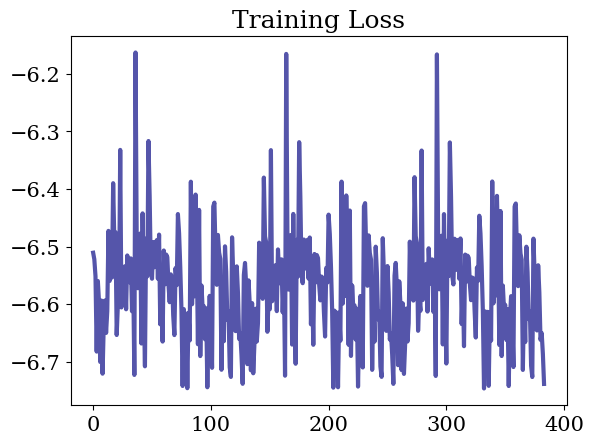

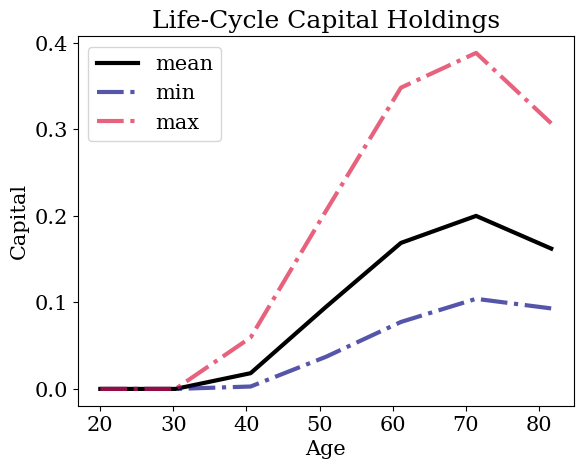

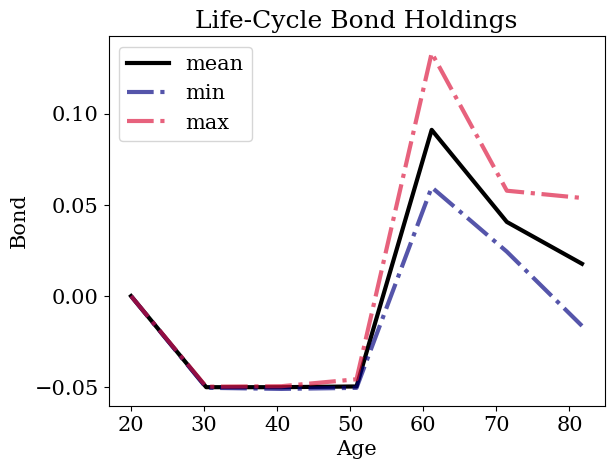

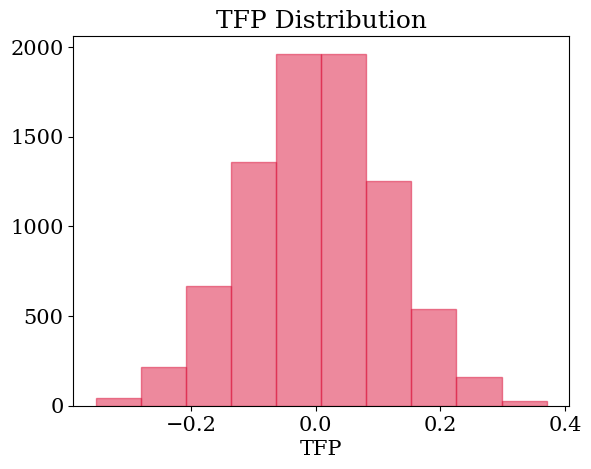

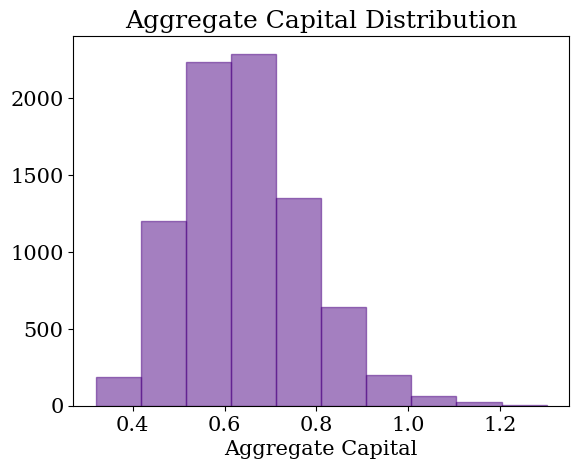

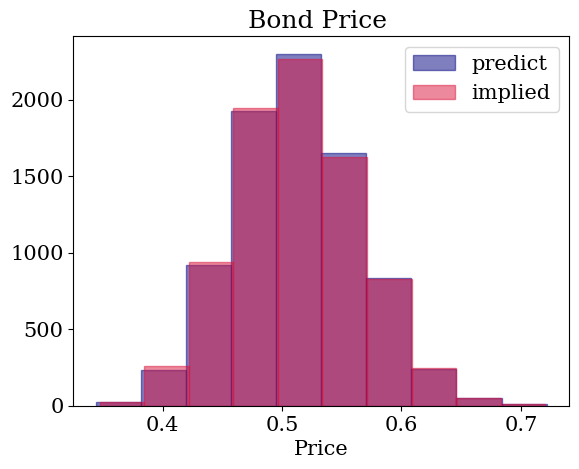

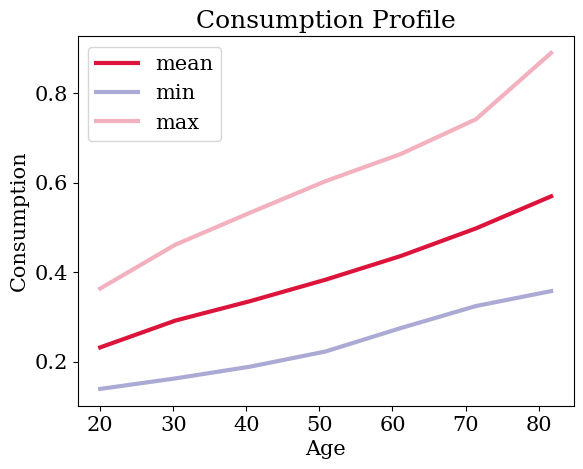

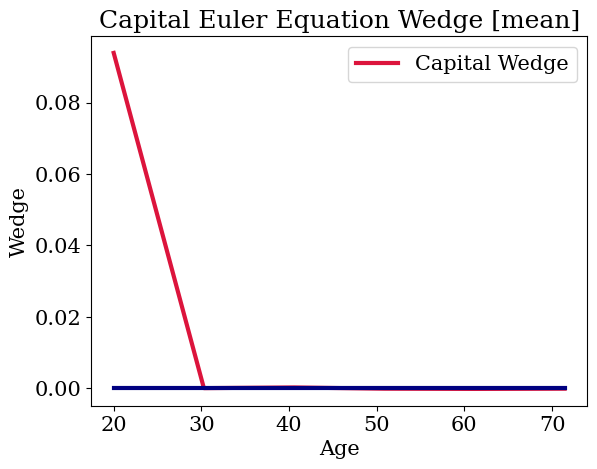

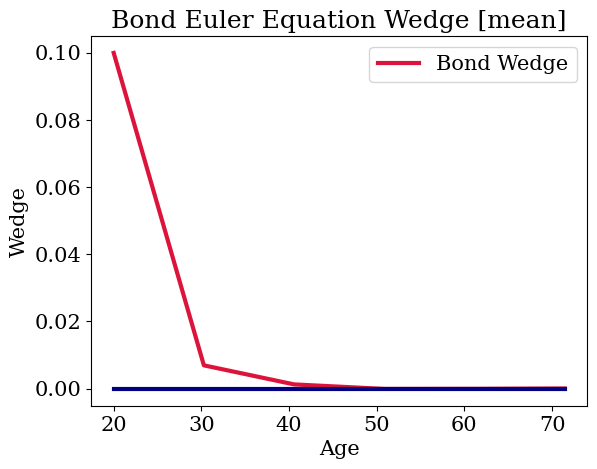

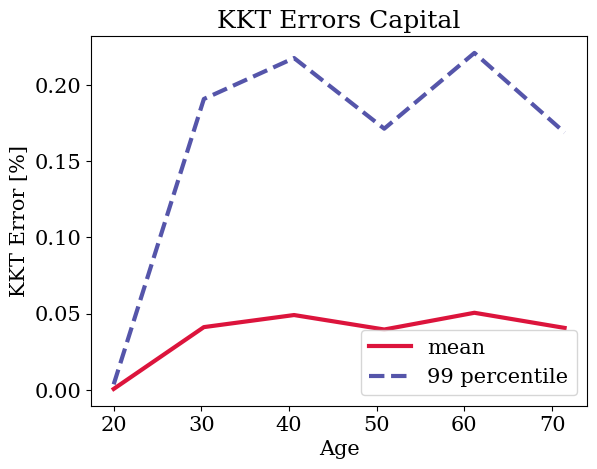

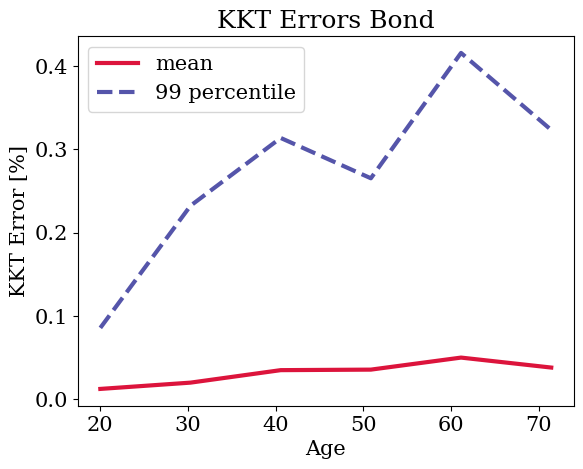

In [ ]:
for i in range(homotopy_steps):
  if i % (int(homotopy_steps / 100)) == 0:
    print('x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x')
    print('Iteration number: '+str(i)+' of '+str(homotopy_steps))
    print('Bond supply: '+str(b_min_space[i]))

  # Update homotopy parameter
  Homotopy_second = Homotopy_second.at[idx_h_b_min].set(b_min_space[i])

  # Train
  theta_second, states_second, loss_second, opt_state_second = CloudMethod(steps_per_homotopy, second_key[i], states_second, Gamma, theta_second, Homotopy_second, shock_mult, opt_state_second)

  # Loss plot
  if i%(int(homotopy_steps / 20))==0:
    plt.plot(jnp.log10(loss_second),color='navy',alpha=2/3)
    plt.title('Training Loss')
    plt.show()

  # Main plotting
  if i%(int(homotopy_steps / 5))==0:
    generate_plots(states_second, theta_second, Homotopy_second)

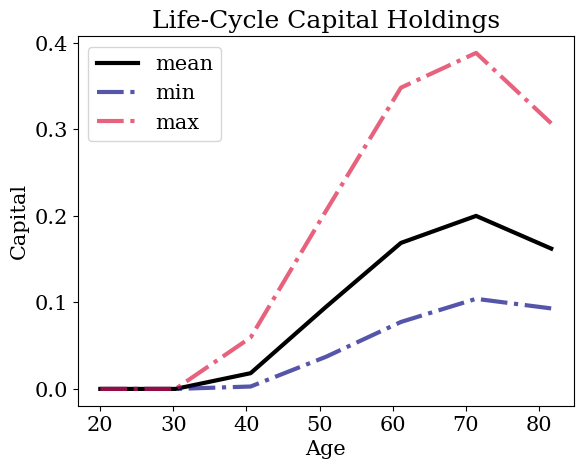

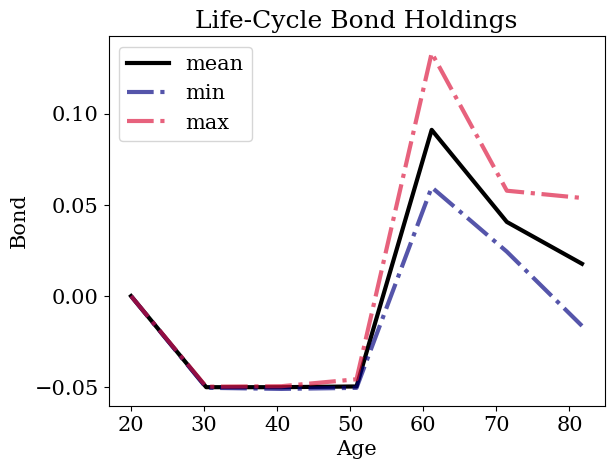

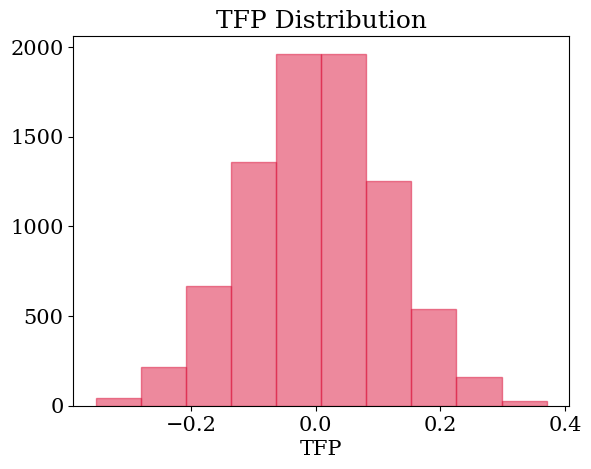

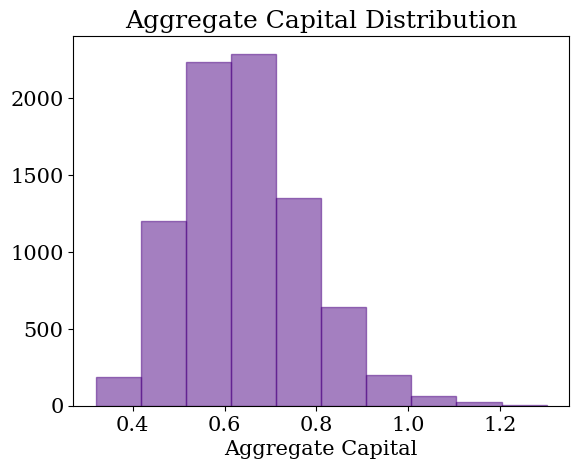

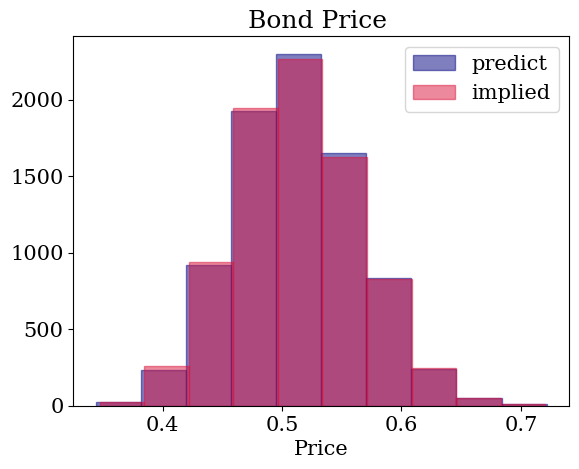

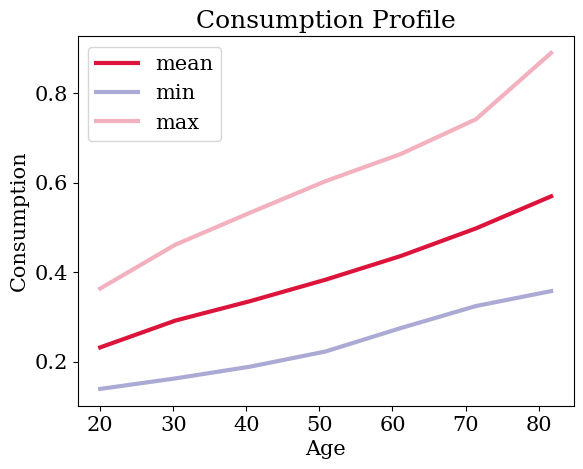

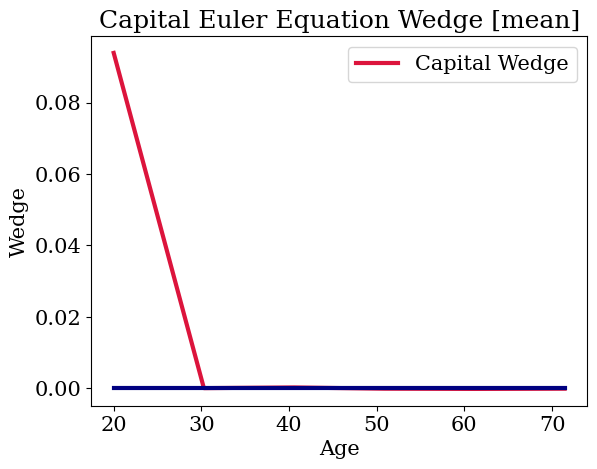

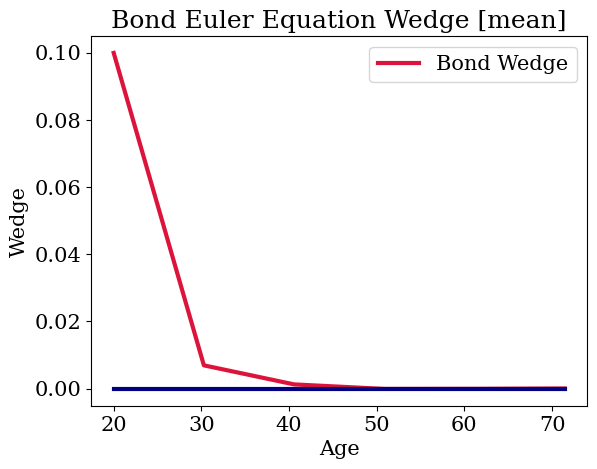

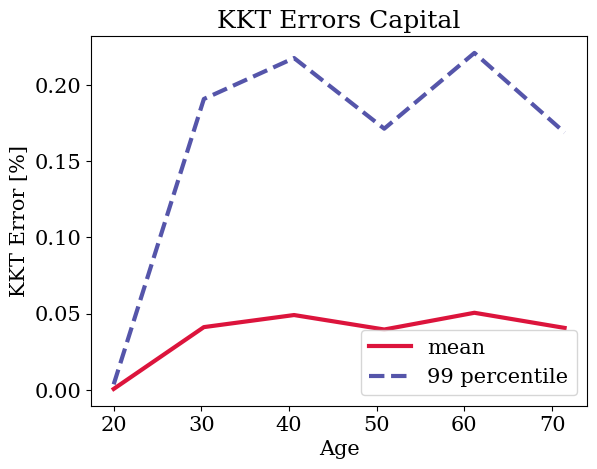

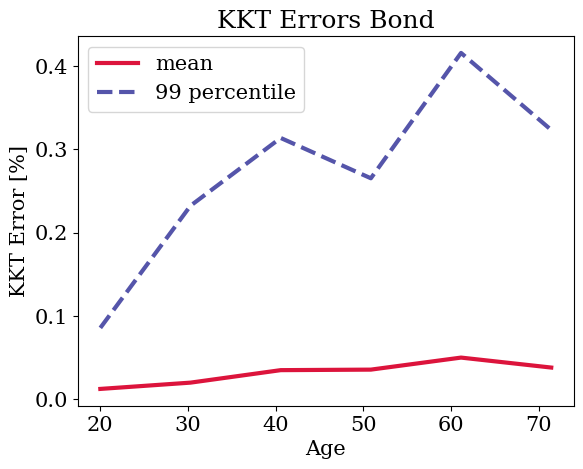

In [ ]:
generate_plots(states_second, theta_second, Homotopy_second)

Lastly we keep training the model with the final parameter configuration.

In [ ]:
final_key = jax.random.PRNGKey(1661)

In [ ]:
# on a T4 GPU, the function call takes 3 to 4 minutes
theta_final, states_final, loss_final, opt_state_final = CloudMethod(2024, final_key, states_second, Gamma, theta_second, Homotopy_second, shock_mult, opt_state_second)

<ipython-input-24-3a63471830d8>:10: DeprecationWarning: The newshape argument of jax.numpy.reshape is deprecated and setting it will soon raise an error. To avoid an error in the future, and to suppress this warning, please use the shape argument instead.
  loss_field = jnp.reshape(loss_field, newshape = (cloud_steps * steps_epoch,))


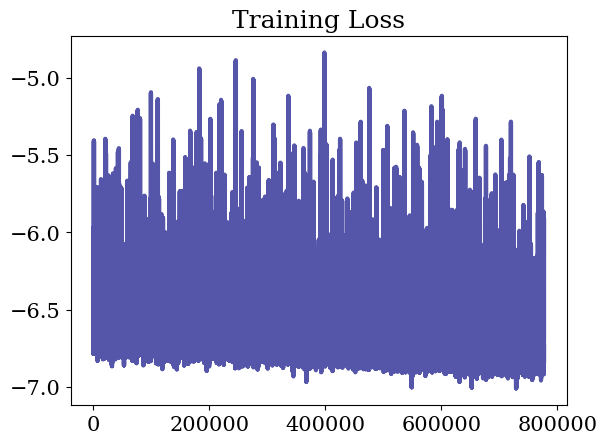

In [ ]:
plt.plot(jnp.log10(loss_final),color='navy',alpha=2/3)
plt.title('Training Loss')
plt.show()

In the very end, we also train with a lower learning rate for some fine tuning.

In [ ]:
Gamma_fine = Gamma / 10 # lower learning rate
fine_key = final_key + 1 # new random ket

In [ ]:
# on a T4 GPU, the function call takes 3 to 4 minutes
theta_final_fine, states_final_fine, loss_final_fine, opt_state_final_fine = CloudMethod(124, fine_key, states_final, Gamma_fine, theta_final, Homotopy_second, shock_mult, opt_state_final)

<ipython-input-24-3a63471830d8>:10: DeprecationWarning: The newshape argument of jax.numpy.reshape is deprecated and setting it will soon raise an error. To avoid an error in the future, and to suppress this warning, please use the shape argument instead.
  loss_field = jnp.reshape(loss_field, newshape = (cloud_steps * steps_epoch,))


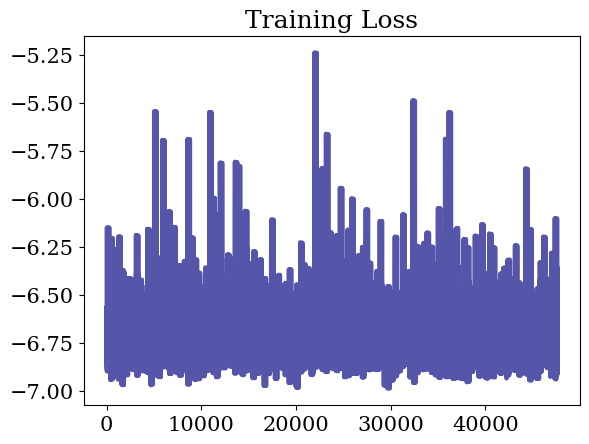

In [ ]:
plt.plot(jnp.log10(loss_final_fine),color='navy',alpha=2/3)
plt.title('Training Loss')
plt.show()

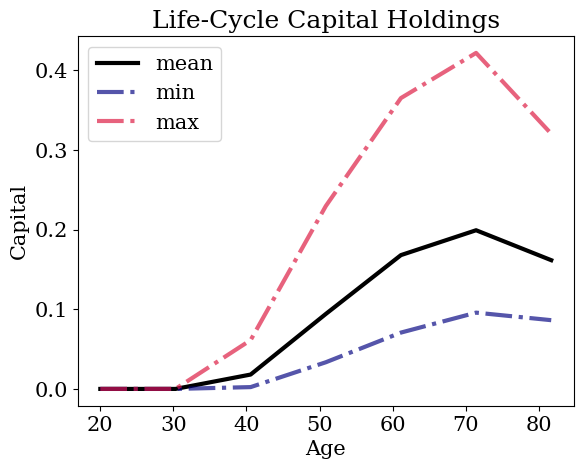

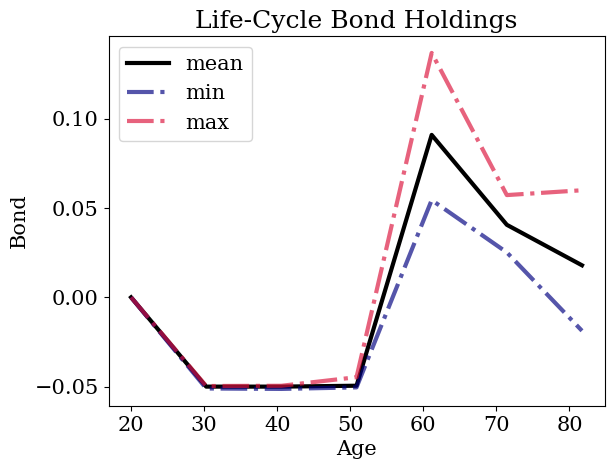

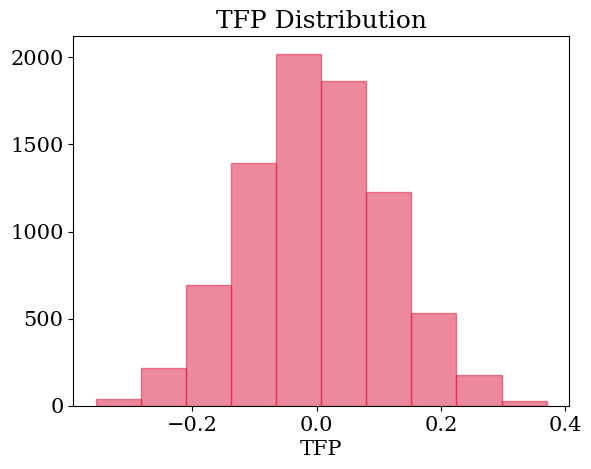

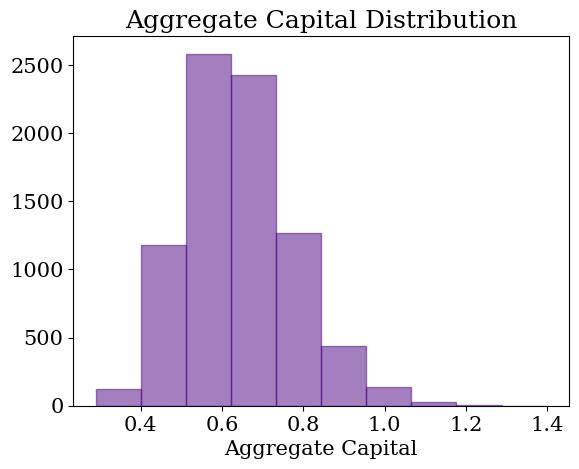

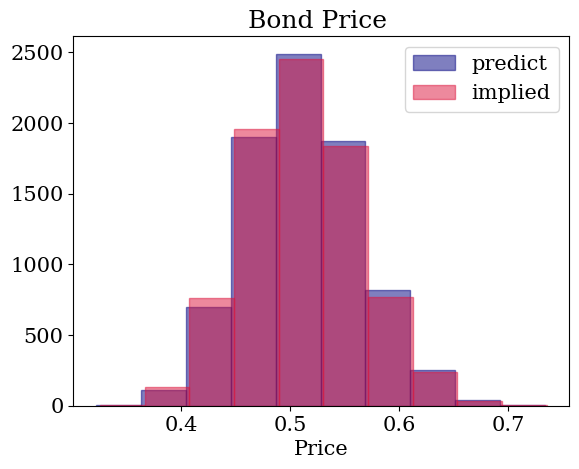

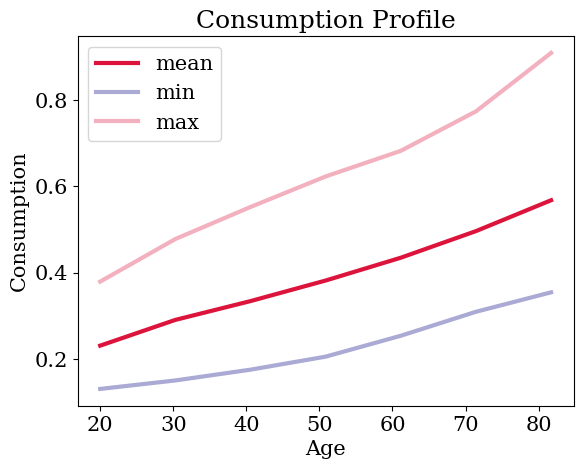

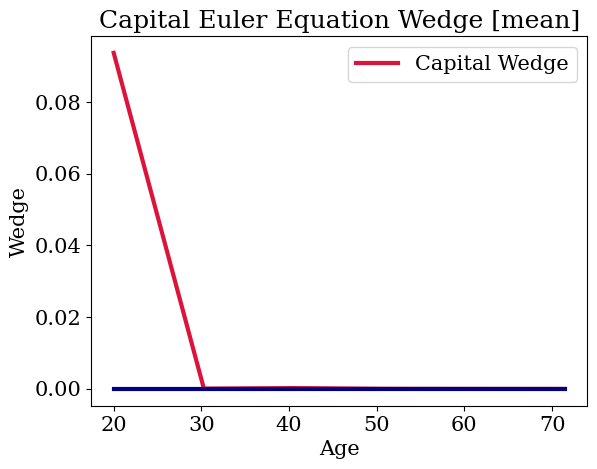

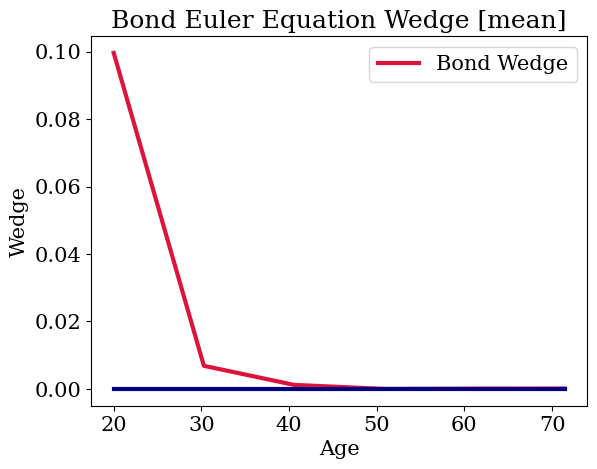

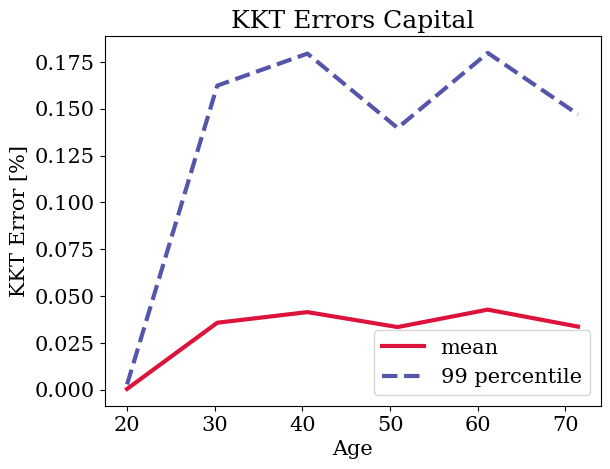

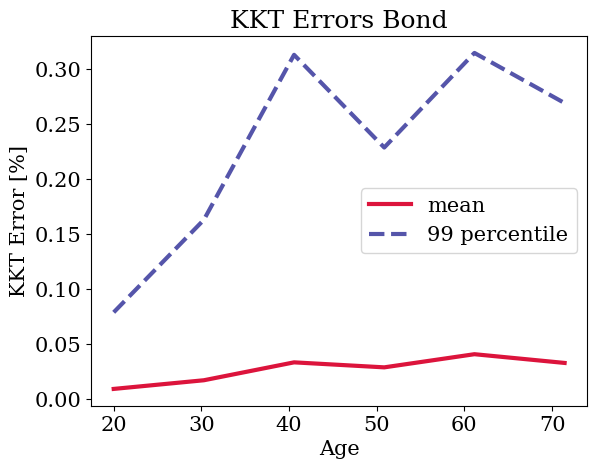

In [ ]:
generate_plots(states_final_fine, theta_final_fine, Homotopy_second)